# Parsing Hap.py outputs: Parsing Hap.py VC performance data

### Import Statements

In [2]:
import numpy as np
import pandas as pd
import vcf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import plotly.express as px
import statsmodels.api as sm

%matplotlib inline

#### Pandas Viewing Settings

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Set matplotlib text export settings for Adobe Illustrator

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Parse info regarding samples of interest

In [5]:
Repo_DataDir = "../../Data"

PMP_SM_ResultsSummary_Dir_210108 = Repo_DataDir + "/210108_PMP_SM_50CI_V7_ResultsSummary"


PMP_50CI_AssemblySummary_TSV_PATH = PMP_SM_ResultsSummary_Dir_210108 + "/210108_PMP_50CI_AssemblySummary_V7.tsv"

PMP_42CI_CicularOnly_AssemblySummary_TSV_PATH = PMP_SM_ResultsSummary_Dir_210108 + "/210108_PMP_42CI_CircularOnly_F2Filtered_AssemblySummary_V7.tsv" 

PMP_36CI_CicularOnly_F2Filtered_AtLeast40XIllDepth_AssemblySummary_TSV_PATH = PMP_SM_ResultsSummary_Dir_210108 + "/210108_PMP_36CI_CircularOnly_F2Filtered_AtLeast40XMeanDepthIllumina_AssemblySummary_V7.tsv"       


PMP_50CI_AssemblySummary = pd.read_csv(PMP_50CI_AssemblySummary_TSV_PATH, sep = "\t")

PMP_42CI_CicularOnly_AssemblySummary = pd.read_csv(PMP_42CI_CicularOnly_AssemblySummary_TSV_PATH, sep = "\t")

PMP_36CI_CicularOnly_F2Filtered_AtLeast40XDepth_AssemblySummary = pd.read_csv(PMP_36CI_CicularOnly_F2Filtered_AtLeast40XIllDepth_AssemblySummary_TSV_PATH, sep = "\t")

PMP_36CI_AnalysisSet_AssemblySummary = PMP_36CI_CicularOnly_F2Filtered_AtLeast40XDepth_AssemblySummary


SampleIDs_36CI_SOI = list( PMP_36CI_AnalysisSet_AssemblySummary["SampleID"].values )


print(','.join(SampleIDs_36CI_SOI) )

# Make sample to lineage mapping dict

ID_To_IlluminaAvrgCov_Dict = dict(PMP_50CI_AssemblySummary[['SampleID', 'IlluminaWGSToH37rv_AvrgCov']].values)                     
ID_To_Lineage_Dict = dict(PMP_50CI_AssemblySummary[['SampleID', 'PrimaryLineage_PB']].values)
ID_To_Dataset_Dict = dict(PMP_50CI_AssemblySummary[['SampleID', 'Dataset_Tag']].values)

M0011368_9,M0014888_3,M0016395_7,M0010874_7,01_R1430,02_R0894,02_R1708,02_R1896,M0016737_0,M0017522_5,01_R1134,M0003941_3,02_R1179,N1176,N0072,N0153,N0145,N0155,N0004,N1274,N0054,N1272,N0091,N1202,N1177,RW-TB008,DNA028,DNA075,DNA091,DNA044,DNA020,AZE_02_042,DNA019_Rose,DNA120,DNA188,DNA086


In [6]:
PMP_36CI_AnalysisSet_AssemblySummary.head()

,SampleID,numContigs_Complete,circContig_Length,circContig_Cov,PacBio_Subread_Median_Length,LineageCall_Illumina,LineageCall_PacBio,F2_Illumina,F2_PacBio,ANI_I3,ANI_I3_PP,IlluminaWGSToH37rv_AvrgCov,PacBio_Subreads_H37Rv_AvrgCov,NumAnno_ORFs_PB_PilonPolished,NumAnno_ORFs_PB_DeNovo,GCcontent_PB_PP_GBK,NumChanges_PilonPolished,NumSNPs_PilonPolished,NumTotalInsertions_PilonPolished,Num1bpInsertion_PilonPolished,Num2bpInsertion_PilonPolished,NumTotalDeletions_PilonPolished,Num1bpDeletion_PilonPolished,PrimaryLineage_PB,PrimaryLineage_Ill,Dataset_Tag
0,M0011368_9,1,4397765,203,3773.0,"lineage4,lineage4.4,lineage4.4.1","lineage4,lineage4.4,lineage4.4.1",0.004937,0.305222,99.9368,99.9364,40,191,4050,4075,65.614721,63,0,59,58,1,4,4,lineage4,lineage4,Farhat_Peru_2019
1,M0014888_3,1,4399966,194,5038.0,"lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1","lineage4,lineage4.1,lineage4.1.2,lineage4.1.2.1",0.007132,0.279607,99.9185,99.9193,77,182,4048,4060,65.635971,39,0,39,39,0,0,0,lineage4,lineage4,Farhat_Peru_2019
2,M0016395_7,1,4420916,195,4621.0,"lineage4,lineage4.3,lineage4.3.2","lineage4,lineage4.3,lineage4.3.2",0.003671,0.299199,99.9248,99.9262,43,183,4068,4096,65.615829,71,1,66,65,1,4,4,lineage4,lineage4,Farhat_Peru_2019
3,M0010874_7,1,4396274,172,4675.0,"lineage4,lineage4.3,lineage4.3.3","lineage4,lineage4.3,lineage4.3.3",0.002880,0.289791,99.9283,99.9310,89,161,4054,4103,65.614744,111,9,95,95,0,7,6,lineage4,lineage4,Farhat_Peru_2019
4,01_R1430,1,4409128,227,6009.0,"lineage4,lineage4.4,lineage4.4.1","lineage4,lineage4.4,lineage4.4.1",0.005372,0.295069,99.9284,99.9290,253,212,4070,4119,65.613390,93,0,90,89,0,3,3,lineage4,lineage4,Farhat_Peru_2019


In [7]:
#SampleIDs_31CI_WiCircA

## Construct dictionary with PATHs to relevant files for all samples

### Define directories to PMP-SM (PacBio assembly and analysis pipeline)

In [8]:
### Define directories to PMP-SM (PacBio assembly and analysis pipeline)

### Define varaint calling pipeline output directories

PacBio_ProjectDir = "/n/data1/hms/dbmi/farhat/mm774/Projects/PacBio_Evaluation_Project"

PMP_SM_Outputs_Dir = PacBio_ProjectDir + "/PacmanPipe_SM_Outputs"

PMP_SM_TB_Portals_R1_Illumina_WGS_201201_OutputDir = PMP_SM_Outputs_Dir + "/201201_PMP_SM_TB_Portals_R1_Output_V2"



In [9]:
!ls -lah $PMP_SM_83CI_191203_OutputDir/M0011368_9/Hap.py_VariantCalling_EvalDir/PBMM2_Paftools_GroundTruthVCF_Evaluations_V1         

ls: cannot access /M0011368_9/Hap.py_VariantCalling_EvalDir/PBMM2_Paftools_GroundTruthVCF_Evaluations_V1: No such file or directory


In [10]:
!ls -1 $PMP_SM_83CI_191203_OutputDir/M0011368_9/Hap.py_VariantCalling_EvalDir/M0011368_9_Happy_VCeval_T_PB_G3PP_MM2_Vs_Q_Ill_Pilon_VCs_HicksRegionsRemoval

ls: cannot access /M0011368_9/Hap.py_VariantCalling_EvalDir/M0011368_9_Happy_VCeval_T_PB_G3PP_MM2_Vs_Q_Ill_Pilon_VCs_HicksRegionsRemoval: No such file or directory


## Save the PATHs of HapPy analysis from the following masking schemes:

1) "None" <br>


In [11]:
SampleID_ToPaths_Dict = {}

for SampleID in SampleIDs_36CI_SOI:

    SampleID_ToPaths_Dict[SampleID] = {}    
    
    # Defining PATHs for PacBio data output (PacmanPipe-V4)
    sample_PMP_OutputDir = PMP_SM_TB_Portals_R1_Illumina_WGS_201201_OutputDir + "/" + SampleID
    Happy_OutDir = f"{sample_PMP_OutputDir}/Hap.py_VariantCalling_EvalDir/PBMM2_Paftools_GroundTruthVCF_Evaluations_V3_minMQ_1_minDP_5_Fix_All_Breaks_AmbRegionsRemoved"
    
    
    # No Masking ("None")
    RegionFilteringScheme = "MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_SVs_4regions"
    SampleID_ToPaths_Dict[SampleID][RegionFilteringScheme] = {}
    SampleID_ToPaths_Dict[SampleID][RegionFilteringScheme]["SNPs"] = {}
    SampleID_ToPaths_Dict[SampleID][RegionFilteringScheme]["INDELs"] = {}
    SampleID_ToPaths_Dict[SampleID][RegionFilteringScheme]["ALL"] = {}
    
    Happy_Sample_Dir = f"{Happy_OutDir}/{SampleID}_Happy_VCeval_T_PB_G3PP_MM2_paftools_Vs_Q_Ill_Pilon_VCs_SNPsINDELs_NoRegionsRemoved_StratifiedBy_PmapAndSVs_4sets_SV_LengthFiltered_50bp_V2"       
    
    Happy_G3PP_Vs_Pilon_ROC_SNPs_PASS_CSV = f"{Happy_Sample_Dir}/Hap.py.{SampleID}.roc.Locations.SNP.PASS.csv.gz"
    Happy_G3PP_Vs_Pilon_ROC_INDELs_PASS_CSV = f"{Happy_Sample_Dir}/Hap.py.{SampleID}.roc.Locations.INDEL.PASS.csv.gz"
    Happy_G3PP_Vs_Pilon_ROC_ALL_PASS_CSV = f"{Happy_Sample_Dir}/Hap.py.{SampleID}.roc.all.csv.gz"

    SampleID_ToPaths_Dict[SampleID][RegionFilteringScheme]["SNPs"]["Happy_ROC_PASS_CSV"] = Happy_G3PP_Vs_Pilon_ROC_SNPs_PASS_CSV
    SampleID_ToPaths_Dict[SampleID][RegionFilteringScheme]["INDELs"]["Happy_ROC_PASS_CSV"] = Happy_G3PP_Vs_Pilon_ROC_INDELs_PASS_CSV         
    SampleID_ToPaths_Dict[SampleID][RegionFilteringScheme]["ALL"]["Happy_ROC_PASS_CSV"] = Happy_G3PP_Vs_Pilon_ROC_ALL_PASS_CSV



In [12]:
SampleID = "N0153"
SampleID = "M0011368_9"
SampleID = "01_R1134"



RegionFilteringScheme = "MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_SVs_4regions"

input_HapPy_ROC_ALL_CSV_PATH = SampleID_ToPaths_Dict[SampleID][RegionFilteringScheme]["ALL"]["Happy_ROC_PASS_CSV"]   


In [13]:
Sample_ROC_ALL_DF = pd.read_csv(input_HapPy_ROC_ALL_CSV_PATH)
#Sample_ROC_ALL_DF["QQ"] = Sample_ROC_ALL_DF["QQ"].astype(int)
Sample_ROC_ALL_PASS_DF = Sample_ROC_ALL_DF[ Sample_ROC_ALL_DF["Filter"] == "PASS"]
i_ALL_PASS_INDEL_DF = Sample_ROC_ALL_PASS_DF[ Sample_ROC_ALL_PASS_DF["Type"] == "INDEL"]
i_ALL_PASS_SNP_DF = Sample_ROC_ALL_PASS_DF[ Sample_ROC_ALL_PASS_DF["Type"] == "SNP"]

In [14]:
i_ALL_PASS_SNP_DF.shape

(107, 65)

In [15]:
i_ALL_PASS_SNP_DF.head()

,Type,Subtype,Subset,Filter,Genotype,QQ.Field,QQ,METRIC.Recall,METRIC.Precision,METRIC.Frac_NA,METRIC.F1_Score,FP.gt,FP.al,Subset.Size,Subset.IS_CONF.Size,Subset.Level,TRUTH.TOTAL,TRUTH.TOTAL.ti,TRUTH.TOTAL.tv,TRUTH.TOTAL.het,TRUTH.TOTAL.homalt,TRUTH.TOTAL.TiTv_ratio,TRUTH.TOTAL.het_hom_ratio,TRUTH.TP,TRUTH.TP.ti,TRUTH.TP.tv,TRUTH.TP.het,TRUTH.TP.homalt,TRUTH.TP.TiTv_ratio,TRUTH.TP.het_hom_ratio,TRUTH.FN,TRUTH.FN.ti,TRUTH.FN.tv,TRUTH.FN.het,TRUTH.FN.homalt,TRUTH.FN.TiTv_ratio,TRUTH.FN.het_hom_ratio,QUERY.TOTAL,QUERY.TOTAL.ti,QUERY.TOTAL.tv,QUERY.TOTAL.het,QUERY.TOTAL.homalt,QUERY.TOTAL.TiTv_ratio,QUERY.TOTAL.het_hom_ratio,QUERY.TP,QUERY.TP.ti,QUERY.TP.tv,QUERY.TP.het,QUERY.TP.homalt,QUERY.TP.TiTv_ratio,QUERY.TP.het_hom_ratio,QUERY.FP,QUERY.FP.ti,QUERY.FP.tv,QUERY.FP.het,QUERY.FP.homalt,QUERY.FP.TiTv_ratio,QUERY.FP.het_hom_ratio,QUERY.UNK,QUERY.UNK.ti,QUERY.UNK.tv,QUERY.UNK.het,QUERY.UNK.homalt,QUERY.UNK.TiTv_ratio,QUERY.UNK.het_hom_ratio
327,SNP,*,*,PASS,*,INFO.MQ,*,0.848548,0.995104,0.006083,0.916001,0,0,4411532.0,4400981.0,0.0,964,590.000000,374.000000,0.000000,964.000000,1.57754,0.0,818,505.000000,313.000000,0.000000,818.000000,1.613419,0.0,146,85.000000,61.000000,0.000000,146.000000,1.393443,0.0,822,507.000000,315.000000,0.000000,822.000000,1.609524,0.0,813,502.000000,311.000000,0.000000,813.000000,1.614148,0.0,4,1.000000,3.000000,0.000000,4.000000,0.333333,0.0,5,4.000000,1.000000,0.000000,5.000000,4.0,0.0
328,SNP,*,*,PASS,*,INFO.MQ,0.000000,0.848548,0.995104,0.006083,0.916001,0,0,4411532.0,4400981.0,0.0,964,590.000000,374.000000,.,.,1.57754,NaN,818,505.000000,313.000000,.,.,1.613419,NaN,146,85.000000,61.000000,.,.,1.393443,NaN,822,507.000000,315.000000,.,.,1.609524,NaN,813,502.000000,311.000000,.,.,1.614148,NaN,4,1.000000,3.000000,.,.,0.333333,NaN,5,4.000000,1.000000,.,.,4.0,NaN
329,SNP,*,*,PASS,*,INFO.MQ,20.000000,0.848548,0.996324,0.006090,0.916517,0,0,4411532.0,4400981.0,0.0,964,.,374.000000,.,.,NaN,NaN,818,.,313.000000,.,.,NaN,NaN,146,.,61.000000,.,.,NaN,NaN,821,.,314.000000,.,.,NaN,NaN,813,.,311.000000,.,.,NaN,NaN,3,.,2.000000,.,.,NaN,NaN,5,.,1.000000,.,.,NaN,NaN
330,SNP,*,*,PASS,*,INFO.MQ,24.000000,0.848548,0.996319,0.006098,0.916515,0,0,4411532.0,4400981.0,0.0,964,590.000000,374.000000,.,.,1.57754,NaN,818,504.000000,312.000000,.,.,1.615385,NaN,146,86.000000,62.000000,.,.,1.387097,NaN,820,507.000000,314.000000,.,.,1.614650,NaN,812,502.000000,311.000000,.,.,1.614148,NaN,3,1.000000,2.000000,.,.,0.500000,NaN,5,4.000000,1.000000,.,.,4.0,NaN
331,SNP,*,*,PASS,*,INFO.MQ,28.000000,0.844398,0.996310,0.006112,0.914086,0,0,4411532.0,4400981.0,0.0,964,.,374.000000,.,.,NaN,NaN,814,.,310.000000,.,.,NaN,NaN,150,.,64.000000,.,.,NaN,NaN,818,.,312.000000,.,.,NaN,NaN,810,.,309.000000,.,.,NaN,NaN,3,.,2.000000,.,.,NaN,NaN,5,.,1.000000,.,.,NaN,NaN


In [16]:
i_ALL_PASS_SNP_DF["Subset"].value_counts()

*                31
TS_contained     30
LowPmap_NoSV     28
HighPmap_NoSV    10
LowPmap_WiSV      5
HighPmap_WiSV     3
Name: Subset, dtype: int64

In [17]:
i_ALL_PASS_SNP_DF.shape

(107, 65)

In [18]:
i_ALL_PASS_SNP_DF[ i_ALL_PASS_SNP_DF["Subset"] == "HighPmap_NoSV" ].head(12)

,Type,Subtype,Subset,Filter,Genotype,QQ.Field,QQ,METRIC.Recall,METRIC.Precision,METRIC.Frac_NA,METRIC.F1_Score,FP.gt,FP.al,Subset.Size,Subset.IS_CONF.Size,Subset.Level,TRUTH.TOTAL,TRUTH.TOTAL.ti,TRUTH.TOTAL.tv,TRUTH.TOTAL.het,TRUTH.TOTAL.homalt,TRUTH.TOTAL.TiTv_ratio,TRUTH.TOTAL.het_hom_ratio,TRUTH.TP,TRUTH.TP.ti,TRUTH.TP.tv,TRUTH.TP.het,TRUTH.TP.homalt,TRUTH.TP.TiTv_ratio,TRUTH.TP.het_hom_ratio,TRUTH.FN,TRUTH.FN.ti,TRUTH.FN.tv,TRUTH.FN.het,TRUTH.FN.homalt,TRUTH.FN.TiTv_ratio,TRUTH.FN.het_hom_ratio,QUERY.TOTAL,QUERY.TOTAL.ti,QUERY.TOTAL.tv,QUERY.TOTAL.het,QUERY.TOTAL.homalt,QUERY.TOTAL.TiTv_ratio,QUERY.TOTAL.het_hom_ratio,QUERY.TP,QUERY.TP.ti,QUERY.TP.tv,QUERY.TP.het,QUERY.TP.homalt,QUERY.TP.TiTv_ratio,QUERY.TP.het_hom_ratio,QUERY.FP,QUERY.FP.ti,QUERY.FP.tv,QUERY.FP.het,QUERY.FP.homalt,QUERY.FP.TiTv_ratio,QUERY.FP.het_hom_ratio,QUERY.UNK,QUERY.UNK.ti,QUERY.UNK.tv,QUERY.UNK.het,QUERY.UNK.homalt,QUERY.UNK.TiTv_ratio,QUERY.UNK.het_hom_ratio
368,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,*,0.974079,1.0,0.0,0.986869,0,0,4200562.0,4196889.0,0.0,733,453.000000,280.000000,0.000000,733.000000,1.617857,0.0,714,444.000000,270.000000,0.000000,714.000000,1.644444,0.0,19,9.000000,10.000000,0.000000,19.000000,0.900000,0.0,714,444.000000,270.000000,0.000000,714.000000,1.644444,0.0,714,444.000000,270.000000,0.000000,714.000000,1.644444,0.0,0,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0,0.000000,0.000000,0.000000,0.000000,NaN,NaN
369,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,0.000000,0.974079,1.0,0.0,0.986869,0,0,4200562.0,4196889.0,0.0,733,453.000000,280.000000,.,.,1.617857,NaN,714,444.000000,270.000000,.,.,1.644444,NaN,19,9.000000,10.000000,.,.,0.900000,NaN,714,444.000000,270.000000,.,.,1.644444,NaN,714,444.000000,270.000000,.,.,1.644444,NaN,0,0.000000,0.000000,.,.,NaN,NaN,0,0.000000,0.000000,.,.,NaN,NaN
370,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,28.000000,0.974079,1.0,0.0,0.986869,0,0,4200562.0,4196889.0,0.0,733,.,280.000000,.,.,NaN,NaN,714,.,270.000000,.,.,NaN,NaN,19,.,10.000000,.,.,NaN,NaN,713,.,269.000000,.,.,NaN,NaN,713,.,269.000000,.,.,NaN,NaN,0,.,0.000000,.,.,NaN,NaN,0,.,0.000000,.,.,NaN,NaN
371,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,43.000000,0.971351,1.0,0.0,0.985467,0,0,4200562.0,4196889.0,0.0,733,453.000000,.,.,.,NaN,NaN,712,443.000000,.,.,.,NaN,NaN,21,10.000000,.,.,.,NaN,NaN,713,444.000000,.,.,.,NaN,NaN,713,444.000000,.,.,.,NaN,NaN,0,0.000000,.,.,.,NaN,NaN,0,0.000000,.,.,.,NaN,NaN
372,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,46.000000,0.971351,1.0,0.0,0.985467,0,0,4200562.0,4196889.0,0.0,733,.,280.000000,.,.,NaN,NaN,712,.,269.000000,.,.,NaN,NaN,21,.,11.000000,.,.,NaN,NaN,711,.,268.000000,.,.,NaN,NaN,711,.,268.000000,.,.,NaN,NaN,0,.,0.000000,.,.,NaN,NaN,0,.,0.000000,.,.,NaN,NaN
373,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,55.000000,0.967258,1.0,0.0,0.983356,0,0,4200562.0,4196889.0,0.0,733,.,280.000000,.,.,NaN,NaN,709,.,266.000000,.,.,NaN,NaN,24,.,14.000000,.,.,NaN,NaN,710,.,267.000000,.,.,NaN,NaN,710,.,267.000000,.,.,NaN,NaN,0,.,0.000000,.,.,NaN,NaN,0,.,0.000000,.,.,NaN,NaN
374,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,57.000000,0.965894,1.0,0.0,0.982651,0,0,4200562.0,4196889.0,0.0,733,453.000000,.,.,.,NaN,NaN,708,442.000000,.,.,.,NaN,NaN,25,11.000000,.,.,.,NaN,NaN,709,443.000000,.,.,.,NaN,NaN,709,443.000000,.,.,.,NaN,NaN,0,0.000000,.,.,.,NaN,NaN,0,0.000000,.,.,.,NaN,NaN
375,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,58.000000,0.964529,1.0,0.0,0.981944,0,0,4200562.0,4196889.0,0.0,733,.,280.000000,.,.,NaN,NaN,707,.,266.000000,.,.,NaN,NaN,26,.,14.000000,.,.,NaN,NaN,708,.,265.000000,.,.,NaN,NaN,708,.,265.000000,.,.,NaN,NaN,0,.,0.000000,.,.,NaN,NaN,0,.,0.000000,.,.,NaN,NaN
376,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,59.000000,0.959072,1.0,0.0,0.979109,0,0,4200562.0,4196889.0,0.0,733,453.000000,280.000000,.,.,1.617857,NaN,703,442.000000,261.000000,.,.,1.693487,NaN,30,11.000000,19.000000,.,.,0.578947,NaN,702,441.000000,260.000000,.,.,1.696154,NaN,702,441.000000,260.000000,.,.,1.696154,NaN,0,0.000000,0.000000,.,.,NaN,NaN,0,0.000000,0.000000,.,.,NaN,NaN
377,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,

In [19]:
i_ALL_PASS_SNP_DF[ i_ALL_PASS_SNP_DF["Subset"] == "HighPmap_NoSV" ].head(3)

,Type,Subtype,Subset,Filter,Genotype,QQ.Field,QQ,METRIC.Recall,METRIC.Precision,METRIC.Frac_NA,METRIC.F1_Score,FP.gt,FP.al,Subset.Size,Subset.IS_CONF.Size,Subset.Level,TRUTH.TOTAL,TRUTH.TOTAL.ti,TRUTH.TOTAL.tv,TRUTH.TOTAL.het,TRUTH.TOTAL.homalt,TRUTH.TOTAL.TiTv_ratio,TRUTH.TOTAL.het_hom_ratio,TRUTH.TP,TRUTH.TP.ti,TRUTH.TP.tv,TRUTH.TP.het,TRUTH.TP.homalt,TRUTH.TP.TiTv_ratio,TRUTH.TP.het_hom_ratio,TRUTH.FN,TRUTH.FN.ti,TRUTH.FN.tv,TRUTH.FN.het,TRUTH.FN.homalt,TRUTH.FN.TiTv_ratio,TRUTH.FN.het_hom_ratio,QUERY.TOTAL,QUERY.TOTAL.ti,QUERY.TOTAL.tv,QUERY.TOTAL.het,QUERY.TOTAL.homalt,QUERY.TOTAL.TiTv_ratio,QUERY.TOTAL.het_hom_ratio,QUERY.TP,QUERY.TP.ti,QUERY.TP.tv,QUERY.TP.het,QUERY.TP.homalt,QUERY.TP.TiTv_ratio,QUERY.TP.het_hom_ratio,QUERY.FP,QUERY.FP.ti,QUERY.FP.tv,QUERY.FP.het,QUERY.FP.homalt,QUERY.FP.TiTv_ratio,QUERY.FP.het_hom_ratio,QUERY.UNK,QUERY.UNK.ti,QUERY.UNK.tv,QUERY.UNK.het,QUERY.UNK.homalt,QUERY.UNK.TiTv_ratio,QUERY.UNK.het_hom_ratio
368,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,*,0.974079,1.0,0.0,0.986869,0,0,4200562.0,4196889.0,0.0,733,453.000000,280.000000,0.000000,733.000000,1.617857,0.0,714,444.000000,270.000000,0.000000,714.000000,1.644444,0.0,19,9.000000,10.000000,0.000000,19.000000,0.9,0.0,714,444.000000,270.000000,0.000000,714.000000,1.644444,0.0,714,444.000000,270.000000,0.000000,714.000000,1.644444,0.0,0,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0,0.000000,0.000000,0.000000,0.000000,NaN,NaN
369,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,0.000000,0.974079,1.0,0.0,0.986869,0,0,4200562.0,4196889.0,0.0,733,453.000000,280.000000,.,.,1.617857,NaN,714,444.000000,270.000000,.,.,1.644444,NaN,19,9.000000,10.000000,.,.,0.9,NaN,714,444.000000,270.000000,.,.,1.644444,NaN,714,444.000000,270.000000,.,.,1.644444,NaN,0,0.000000,0.000000,.,.,NaN,NaN,0,0.000000,0.000000,.,.,NaN,NaN
370,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,28.000000,0.974079,1.0,0.0,0.986869,0,0,4200562.0,4196889.0,0.0,733,.,280.000000,.,.,NaN,NaN,714,.,270.000000,.,.,NaN,NaN,19,.,10.000000,.,.,NaN,NaN,713,.,269.000000,.,.,NaN,NaN,713,.,269.000000,.,.,NaN,NaN,0,.,0.000000,.,.,NaN,NaN,0,.,0.000000,.,.,NaN,NaN


In [20]:
i_ALL_PASS_SNP_DF_HighPmap_WiSV = i_ALL_PASS_SNP_DF[ i_ALL_PASS_SNP_DF["Subset"] == "HighPmap_NoSV" ].sort_values("QQ")

In [21]:
#df_Z = i_ALL_PASS_SNP_DF_WiSV
#parse_HapPy_Benchmark_DF_and_FFILL(df_Z)

In [22]:
#MM2vsMpileup_NoneRemoved

In [23]:
#parse_HapPy_Benchmark_CSV(  SampleID_ToPaths_Dict["N0153"]["MM2vsGATK_CNN2D_NoneRemoved"]["SNPs"]["Happy_ROC_PASS_CSV"]   )

## Parsing Data from all 36 Mtb isolates

## Define function for parsing VariantCalling Performance

In [24]:
def parse_HapPy_Benchmark_CSV(input_HapPy_ROC_CSV_PATH):
    """ 
    """
    
    Sample_ROC_DF = pd.read_csv(input_HapPy_ROC_CSV_PATH) 
    #Sample_ROC_DF = Sample_ROC_DF.drop(Sample_ROC_DF.index[0])
    Sample_ROC_DF = Sample_ROC_DF.sort_values("QQ")
    Sample_ROC_DF.index = Sample_ROC_DF['QQ']

    Sample_ROC_DF = Sample_ROC_DF.reindex(np.arange(Sample_ROC_DF.QQ.min(), Sample_ROC_DF.QQ.max() + 1), fill_value=np.nan)  
    Sample_ROC_DF["QQ"] = Sample_ROC_DF.index

    Sample_ROC_DF = Sample_ROC_DF.ffill()
    Sample_ROC_DF = Sample_ROC_DF.reset_index(drop=True)
    
    return Sample_ROC_DF
   

In [25]:
def parse_HapPy_Benchmark_CSV_NOFFILL(input_HapPy_ROC_CSV_PATH):
    """ 
    """
    
    Sample_ROC_DF = pd.read_csv(input_HapPy_ROC_CSV_PATH) 
    #Sample_ROC_DF = Sample_ROC_DF.drop(Sample_ROC_DF.index[0])
    Sample_ROC_DF = Sample_ROC_DF.sort_values("QQ")
    Sample_ROC_DF.index = Sample_ROC_DF['QQ']

    #Sample_ROC_DF = Sample_ROC_DF.reindex(np.arange(Sample_ROC_DF.QQ.min(), Sample_ROC_DF.QQ.max() + 1), fill_value=np.nan)  
    Sample_ROC_DF["QQ"] = Sample_ROC_DF.index
    
    return Sample_ROC_DF


In [26]:
def parse_HapPy_Benchmark_DF_and_FFILL(Sample_ROC_DF):
    """ 
    """
    
    Sample_ROC_DF = Sample_ROC_DF[ Sample_ROC_DF["QQ"] != "*"]
    Sample_ROC_DF["QQ"] = Sample_ROC_DF["QQ"].astype(float)
    Sample_ROC_DF = Sample_ROC_DF.sort_values("QQ")
    Sample_ROC_DF.index = Sample_ROC_DF['QQ']
    
    if Sample_ROC_DF.shape[0] <= 1:
        print(Sample_ROC_DF.shape[0] )
        Sample_ROC_DF["QQ"] = -10
        return Sample_ROC_DF

    
    
    Sample_ROC_DF = Sample_ROC_DF.reindex(np.arange(Sample_ROC_DF.QQ.min(), Sample_ROC_DF.QQ.max() + 1), fill_value=np.nan)  
    Sample_ROC_DF["QQ"] = Sample_ROC_DF.index

    Sample_ROC_DF = Sample_ROC_DF.ffill()
    Sample_ROC_DF = Sample_ROC_DF.reset_index(drop=True)
    
    return Sample_ROC_DF


In [27]:
## Modifying the above function to Fill up to MQ == 60 ALWAYS

#### Code based on info from this link: https://stackoverflow.com/questions/19184833/copy-and-add-the-last-line-of-a-python-pandas-data-frame-on-to-itself-with-updat

### UPDATED FFILL PARSER
#### This version adds a QQ==60 row to the dataframe if it doesn't exist

In [28]:
def parse_HapPy_Benchmark_DF_and_FFILL(Sample_ROC_DF):
    """ 
    """
    
    Sample_ROC_DF = Sample_ROC_DF[ Sample_ROC_DF["QQ"] != "*"]
    Sample_ROC_DF["QQ"] = Sample_ROC_DF["QQ"].astype(float)
    Sample_ROC_DF = Sample_ROC_DF.sort_values("QQ")
    
    
    if Sample_ROC_DF.shape[0] <= 1:
        print(Sample_ROC_DF.shape[0] )
        Sample_ROC_DF["QQ"] = -10
        return Sample_ROC_DF

    
    #print(Sample_ROC_DF[-1:].values.shape)
    
    Sample_ROC_DF_lastRow_ToMQ60 = pd.DataFrame(Sample_ROC_DF[-1:].values,  columns=Sample_ROC_DF.columns)
    
    MQ_Thresh_OfLastRow = Sample_ROC_DF_lastRow_ToMQ60["QQ"].values[0]
    
    if MQ_Thresh_OfLastRow != 60:
        Sample_ROC_DF_lastRow_ToMQ60["QQ"] = 60

        Sample_ROC_DF = Sample_ROC_DF.append(Sample_ROC_DF_lastRow_ToMQ60)
    
    Sample_ROC_DF.index = Sample_ROC_DF['QQ']
    
    
    Sample_ROC_DF = Sample_ROC_DF.reindex(np.arange(Sample_ROC_DF.QQ.min(), Sample_ROC_DF.QQ.max() + 1), fill_value=np.nan)  
    Sample_ROC_DF["QQ"] = Sample_ROC_DF.index

    Sample_ROC_DF = Sample_ROC_DF.ffill()
    Sample_ROC_DF = Sample_ROC_DF.reset_index(drop=True)
    
    return Sample_ROC_DF


### UPDATED FFILL PARSER PART #2 
#### This version adds a QQ==60 row to the dataframe if it doesn't exist

This function handles the edge case where NO positive calls were made

In [29]:
def parse_HapPy_Benchmark_DF_and_FFILL_And_Add0_UpTo60QQ(Sample_ROC_DF):
    """ 
    """
    
    Sample_ROC_DF_OG = Sample_ROC_DF.copy()
    
    Sample_ROC_DF = Sample_ROC_DF[ Sample_ROC_DF["QQ"] != "*"]
    Sample_ROC_DF["QQ"] = Sample_ROC_DF["QQ"].astype(float)
    Sample_ROC_DF = Sample_ROC_DF.sort_values("QQ")
    Sample_ROC_DF.index = Sample_ROC_DF['QQ']

    if Sample_ROC_DF.shape[0] <= 1:
        print(Sample_ROC_DF.shape[0] )
        Sample_ROC_DF["QQ"] = -10
        return Sample_ROC_DF

    
    #print(Sample_ROC_DF.shape)

    Sample_ROC_DF_lastRow_ToMQ60 = pd.DataFrame(Sample_ROC_DF.iloc[[-1]].values,  columns=Sample_ROC_DF.columns)
    MQ_Thresh_OfLastRow = Sample_ROC_DF_lastRow_ToMQ60["QQ"].values[0]

    if MQ_Thresh_OfLastRow != 60:
        #print("Max QQ in table", Sample_ROC_DF.QQ.max() )
        Sample_ROC_DF_lastRow_ToMQ60["QQ"] = 60
        Sample_ROC_DF_lastRow_ToMQ60["METRIC.Recall"] = 0 # np.nan #0 # Set Recall to ZERO b/c there are still FN, but not a single one was called
        Sample_ROC_DF_lastRow_ToMQ60["METRIC.Precision"] = np.nan #0  # Set Precision to NAN b/c there were no Positive calls made at all
        Sample_ROC_DF_lastRow_ToMQ60["METRIC.F1_Score"] = 0 # np.nan #0   # Set F1 score to ZERO b/c Recall is ZERO
    

        #Sample_ROC_DF_lastRow_ToMQ60["QUERY.TPs"] = 0
        #Sample_ROC_DF_lastRow_ToMQ60["QUERY.TOTAL] + Sample_ROC_DF_lastRow_ToMQ60["TRUTH.TP"]


        Sample_ROC_DF_lastRow_ToMQ60.index = [60]

        Sample_ROC_DF = Sample_ROC_DF.append(Sample_ROC_DF_lastRow_ToMQ60)


    Sample_ROC_DF = Sample_ROC_DF.reindex(np.arange(Sample_ROC_DF.QQ.min(), Sample_ROC_DF.QQ.max() + 1), fill_value=np.nan)  

    Sample_ROC_DF["QQ"] = Sample_ROC_DF.index

    Sample_ROC_DF = Sample_ROC_DF.ffill()

    Sample_ROC_DF = Sample_ROC_DF.reset_index(drop=True)

    return Sample_ROC_DF


In [30]:
def parse_HapPy_Benchmark_DF_and_FFILL_And_Add0_UpTo60QQ(Sample_ROC_DF):
    """ 
    """
    
    Sample_ROC_DF_OG = Sample_ROC_DF.copy()
    
    Sample_ROC_DF = Sample_ROC_DF[ Sample_ROC_DF["QQ"] != "*"]
    Sample_ROC_DF["QQ"] = Sample_ROC_DF["QQ"].astype(float)
    Sample_ROC_DF = Sample_ROC_DF.sort_values("QQ")
    Sample_ROC_DF.index = Sample_ROC_DF['QQ']

    if Sample_ROC_DF.shape[0] < 1:
        print(Sample_ROC_DF.shape[0] )
        Sample_ROC_DF["QQ"] = -10
        return Sample_ROC_DF

    
    #print(Sample_ROC_DF.shape)

    Sample_ROC_DF_lastRow_ToMQ60 = pd.DataFrame(Sample_ROC_DF.iloc[[-1]].values,  columns=Sample_ROC_DF.columns)
    MQ_Thresh_OfLastRow = Sample_ROC_DF_lastRow_ToMQ60["QQ"].values[0]

    if MQ_Thresh_OfLastRow != 60:
        #print("Max QQ in table", Sample_ROC_DF.QQ.max() )
        Sample_ROC_DF_lastRow_ToMQ60["QQ"] = 60
        Sample_ROC_DF_lastRow_ToMQ60["METRIC.Recall"] = 0 # np.nan #0 # Set Recall to ZERO b/c there are still FN, but not a single one was called
        Sample_ROC_DF_lastRow_ToMQ60["METRIC.Precision"] = 1 #0  # Set Precision to NAN b/c there were no Positive calls made at all
        Sample_ROC_DF_lastRow_ToMQ60["METRIC.F1_Score"] = 0 # np.nan #0   # Set F1 score to ZERO b/c Recall is ZERO
    

        #Sample_ROC_DF_lastRow_ToMQ60["QUERY.TPs"] = 0
        #Sample_ROC_DF_lastRow_ToMQ60["QUERY.TOTAL] + Sample_ROC_DF_lastRow_ToMQ60["TRUTH.TP"]


        Sample_ROC_DF_lastRow_ToMQ60.index = [60]

        Sample_ROC_DF = Sample_ROC_DF.append(Sample_ROC_DF_lastRow_ToMQ60)


    Sample_ROC_DF = Sample_ROC_DF.reindex(np.arange(Sample_ROC_DF.QQ.min(), Sample_ROC_DF.QQ.max() + 1), fill_value=np.nan)  

    Sample_ROC_DF["QQ"] = Sample_ROC_DF.index

    Sample_ROC_DF = Sample_ROC_DF.ffill()

    Sample_ROC_DF = Sample_ROC_DF.reset_index(drop=True)

    return Sample_ROC_DF


In [31]:
SampleID_ToPaths_Dict["N0153"].keys()

dict_keys(['MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_SVs_4regions'])

In [32]:
#i_HapPy_ALL_PASS_SNP_DF.head(2)

In [33]:
#i_ALL_PASS_SNP_DF_Subtype

In [34]:
listOf_FilteringSchemes = ["MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_SVs_4regions"] 


listOf_VariantTypes = ["SNPs", "INDELs"]
listOf_VariantTypes = ["ALL"]
#listOf_VariantTypes = ["SNPs",]
                       
listOf_Stratification_Subsets = ['HighPmap_NoSV', 'HighPmap_WiSV', 'LowPmap_WiSV', 'LowPmap_NoSV',]
#listOf_Stratification_Subsets = ['HighPmap_NoSV', 'LowPmap_NoSV', 'All_WiSV'] # '']


listOf_HapPy_DFs = []

for RegionFilteringScheme in tqdm(listOf_FilteringSchemes):
    for SampleID in (SampleIDs_36CI_SOI):
        for variantType in listOf_VariantTypes:
            

            i_HapPy_ROC_PASS_CSV_PATH = SampleID_ToPaths_Dict[SampleID][RegionFilteringScheme][variantType]["Happy_ROC_PASS_CSV"]                      

            i_HapPy_ALL_DF = pd.read_csv(i_HapPy_ROC_PASS_CSV_PATH)
            i_HapPy_ALL_PASS_DF = i_HapPy_ALL_DF[ i_HapPy_ALL_DF["Filter"] == "PASS"]
            #i_HapPy_ALL_PASS_INDEL_DF = i_HapPy_ALL_PASS_DF[ i_HapPy_ALL_PASS_DF["Type"] == "INDEL"]
            i_HapPy_ALL_PASS_SNP_DF = i_HapPy_ALL_PASS_DF[ i_HapPy_ALL_PASS_DF["Type"] == "SNP"]            
            
            #print(SampleID,  i_HapPy_ALL_PASS_SNP_DF["Subset"].value_counts())
            
            for Stratification_Subset in listOf_Stratification_Subsets:      
                
                i_ALL_PASS_SNP_DF_Subtype = i_HapPy_ALL_PASS_SNP_DF[ i_HapPy_ALL_PASS_SNP_DF["Subset"] == Stratification_Subset]

                #print(RegionFilteringScheme, SampleID, variantType, Stratification_Subset, i_ALL_PASS_SNP_DF_Subtype.QQ.max())

                
                i_ALL_PASS_SNP_DF_Subtype_FF = parse_HapPy_Benchmark_DF_and_FFILL_And_Add0_UpTo60QQ(i_ALL_PASS_SNP_DF_Subtype)
                #print(i_ALL_PASS_SNP_DF_Subtype_FF.QQ.max())
                
                if i_ALL_PASS_SNP_DF_Subtype_FF.shape[0] >= 1: #continue
                    
                    columnsToKeep_HappyTable = ['Type', 'Subtype', 'Subset', 'Filter', 'Genotype', 'QQ.Field',
                                                 'QQ', 'METRIC.Recall', 'METRIC.Precision', 'METRIC.Frac_NA',
                                                 'METRIC.F1_Score', 'TRUTH.TP', 'TRUTH.FN', 'QUERY.TP',
                                                 'QUERY.FP', 'QUERY.UNK']

                    i_VC_PR_Curve_DF = i_ALL_PASS_SNP_DF_Subtype_FF[columnsToKeep_HappyTable]

                    i_VC_PR_Curve_DF.loc[:,'SampleID'] = SampleID
                    i_VC_PR_Curve_DF.loc[:,'RegionFilteringScheme'] = RegionFilteringScheme
                    i_VC_PR_Curve_DF.loc[:,'variantType'] = variantType

                    i_VC_PR_Curve_DF["Count_Col"] = 1 
                    listOf_HapPy_DFs.append(i_VC_PR_Curve_DF)
                else:
                    print("NOT INCLUDING", SampleID, Stratification_Subset, i_ALL_PASS_SNP_DF_Subtype.shape[0], i_ALL_PASS_SNP_DF_Subtype_FF.shape[0], )
                    
                    
                    
            #break
        #break

HapPy_PR_DF_IndividualCurves = pd.concat(listOf_HapPy_DFs)

HapPy_PR_DF_IndividualCurves["QQ"] = HapPy_PR_DF_IndividualCurves["QQ"].astype(int) #Experimental





  0%|          | 0/1 [00:00<?, ?it/s]/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/mm774/conda3/envs/py37_S/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [35]:
# HapPy_PR_DF_IndividualCurves[ (HapPy_PR_DF_IndividualCurves["Subset"] == "HighPmap_NoSV") & (HapPy_PR_DF_IndividualCurves["SampleID"] == "01_R1134") ].sort_values("QQ")

In [36]:
HapPy_PR_DF_IndividualCurves["variantType"].value_counts()

ALL    8453
Name: variantType, dtype: int64

In [37]:
HapPy_PR_DF_IndividualCurves.head()

,Type,Subtype,Subset,Filter,Genotype,QQ.Field,QQ,METRIC.Recall,METRIC.Precision,METRIC.Frac_NA,METRIC.F1_Score,TRUTH.TP,TRUTH.FN,QUERY.TP,QUERY.FP,QUERY.UNK,SampleID,RegionFilteringScheme,variantType,Count_Col
0,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,0,0.949468,1.0,0.0,0.974079,714.0,38.0,714.0,0.0,0.0,M0011368_9,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,1
1,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,1,0.949468,1.0,0.0,0.974079,714.0,38.0,714.0,0.0,0.0,M0011368_9,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,1
2,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,2,0.949468,1.0,0.0,0.974079,714.0,38.0,714.0,0.0,0.0,M0011368_9,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,1
3,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,3,0.949468,1.0,0.0,0.974079,714.0,38.0,714.0,0.0,0.0,M0011368_9,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,1
4,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,4,0.949468,1.0,0.0,0.974079,714.0,38.0,714.0,0.0,0.0,M0011368_9,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,1


In [38]:
HapPy_PR_DF_IndividualCurves["Subset"].value_counts()

LowPmap_NoSV     2196
LowPmap_WiSV     2196
HighPmap_NoSV    2196
HighPmap_WiSV    1865
Name: Subset, dtype: int64

In [39]:
HapPy_PR_DF_IndividualCurves["Subset"].value_counts()

LowPmap_NoSV     2196
LowPmap_WiSV     2196
HighPmap_NoSV    2196
HighPmap_WiSV    1865
Name: Subset, dtype: int64

In [40]:
X = HapPy_PR_DF_IndividualCurves.groupby(["QQ", "RegionFilteringScheme", "variantType", "Subset"]).sum().reset_index()   

In [41]:
X.head()

,QQ,RegionFilteringScheme,variantType,Subset,METRIC.Recall,METRIC.Precision,METRIC.Frac_NA,METRIC.F1_Score,TRUTH.TP,TRUTH.FN,QUERY.TP,QUERY.FP,QUERY.UNK,Count_Col
0,0,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_NoSV,34.776487,35.954681,0.130907,35.351795,42042.0,1377.0,42038.0,55.0,171.0,36
1,0,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,15.995466,23.589979,2.751418,18.160524,234.0,220.0,234.0,49.0,45.0,29
2,0,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_NoSV,22.419259,34.661560,1.082510,27.075793,5371.0,3309.0,5198.0,211.0,202.0,36
3,0,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_WiSV,11.698490,17.151460,3.841822,13.024563,364.0,757.0,364.0,375.0,76.0,36
4,1,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_NoSV,34.776487,35.954681,0.130907,35.351795,42042.0,1377.0,42038.0,55.0,171.0,36


In [42]:
X[ X["Subset"] == "HighPmap_WiSV"].sort_values("Count_Col", ascending=False).head(3)

,QQ,RegionFilteringScheme,variantType,Subset,METRIC.Recall,METRIC.Precision,METRIC.Frac_NA,METRIC.F1_Score,TRUTH.TP,TRUTH.FN,QUERY.TP,QUERY.FP,QUERY.UNK,Count_Col
241,60,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,5.696837,32.366667,4.124242,9.305981,63.0,426.0,79.0,10.0,18.0,36
237,59,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,9.991402,32.783334,4.794301,14.528164,113.0,376.0,118.0,10.0,31.0,36
233,58,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,11.794999,33.022223,4.641515,16.275253,133.0,356.0,142.0,10.0,34.0,36


In [43]:
X[ X["Subset"] == "HighPmap_WiSV"].sort_values("Count_Col", ascending=False).tail(6)

,QQ,RegionFilteringScheme,variantType,Subset,METRIC.Recall,METRIC.Precision,METRIC.Frac_NA,METRIC.F1_Score,TRUTH.TP,TRUTH.FN,QUERY.TP,QUERY.FP,QUERY.UNK,Count_Col
97,24,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,15.919967,24.038914,2.842370,18.240244,232.0,222.0,232.0,39.0,45.0,29
101,25,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,15.919967,24.038914,2.842370,18.240244,232.0,222.0,232.0,39.0,45.0,29
105,26,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,15.919967,24.038914,2.842370,18.240244,232.0,222.0,232.0,39.0,45.0,29
109,27,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,15.919967,24.072247,2.846046,18.259949,232.0,222.0,232.0,38.0,45.0,29
113,28,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,15.919967,24.205581,2.860469,18.328520,232.0,222.0,232.0,35.0,45.0,29
121,30,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,15.919967,24.182854,2.878851,18.316982,232.0,222.0,231.0,35.0,45.0,29


In [44]:
X[ X["Subset"] == "LowPmap_WiSV"].sort_values("Count_Col", ascending=False).tail(6)

,QQ,RegionFilteringScheme,variantType,Subset,METRIC.Recall,METRIC.Precision,METRIC.Frac_NA,METRIC.F1_Score,TRUTH.TP,TRUTH.FN,QUERY.TP,QUERY.FP,QUERY.UNK,Count_Col
99,24,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_WiSV,11.125572,17.285165,3.887136,12.713054,344.0,777.0,346.0,358.0,74.0,36
103,25,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_WiSV,11.010324,17.490412,3.911665,12.672200,340.0,781.0,340.0,351.0,73.0,36
107,26,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_WiSV,10.789394,17.458791,3.876516,12.455102,332.0,789.0,333.0,347.0,72.0,36
111,27,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_WiSV,10.637407,17.515975,3.893397,12.375742,327.0,794.0,328.0,341.0,72.0,36
115,28,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_WiSV,10.544953,17.492680,3.906196,12.300336,322.0,799.0,322.0,337.0,72.0,36
243,60,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_WiSV,0.280556,26.000000,3.400000,1.141818,28.0,1093.0,20.0,5.0,5.0,36


# Average (and calculate Standard Error of the mean) Precision and Recall across all 36 CI

In [45]:
# https://stackoverflow.com/questions/19202093/how-to-select-columns-from-groupby-object-in-pandas
HapPy_Mean_PR_DF = HapPy_PR_DF_IndividualCurves.groupby(["QQ", "RegionFilteringScheme", "variantType", "Subset"]).mean().reset_index()     
HapPy_STD_PR_DF = HapPy_PR_DF_IndividualCurves.groupby(["QQ", "RegionFilteringScheme", "variantType", "Subset"]).std().reset_index()
HapPy_SEM_PR_DF = HapPy_PR_DF_IndividualCurves.groupby(["QQ", "RegionFilteringScheme", "variantType", "Subset"]).sem().reset_index()


ColumnsToMergeOn = ["QQ", "RegionFilteringScheme", "variantType", "Subset"]

HapPy_PR_DF = HapPy_Mean_PR_DF.merge(HapPy_SEM_PR_DF,
                                                     left_on = ColumnsToMergeOn,
                                                     right_on = ColumnsToMergeOn,
                                                     suffixes=('_MEAN', '_SEM') ).reset_index(drop=True)

In [46]:
HapPy_PR_DF.head(1)

,QQ,RegionFilteringScheme,variantType,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,Count_Col_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM,Count_Col_SEM
0,0,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_NoSV,0.966014,0.998741,0.003636,0.981994,1167.833333,38.25,1167.722222,1.527778,4.75,1,0.00334,0.000338,0.000926,0.001706,79.982642,3.429419,79.97791,0.424425,1.209339,0.0


In [47]:
HapPy_PR_DF["Subset"].value_counts()

HighPmap_WiSV    61
HighPmap_NoSV    61
LowPmap_NoSV     61
LowPmap_WiSV     61
Name: Subset, dtype: int64

In [48]:

# Filter PR-Curve results for SNPs
HapPy_PR_DF_SNPs = HapPy_PR_DF.copy()

HapPy_PR_DF_SNPs_QQ_0to45 = HapPy_PR_DF_SNPs[ HapPy_PR_DF_SNPs["QQ"].isin(  [1]  +   list(np.arange(5, 45, 5)) )]
HapPy_PR_DF_SNPs_QQ_0to55 = HapPy_PR_DF_SNPs[ HapPy_PR_DF_SNPs["QQ"].isin(  [1]  +   list(np.arange(5, 55, 5)) )]   
HapPy_PR_DF_SNPs_QQ_0to60 = HapPy_PR_DF_SNPs[ HapPy_PR_DF_SNPs["QQ"].isin(  [1]  +   list(np.arange(5, 65, 5)) )]   


NoSV_Subsets_List = ["HighPmap_NoSV", "LowPmap_NoSV"]
WithSV_Subsets_List = ["HighPmap_WiSV", "LowPmap_WiSV"]


HapPy_PR_DF_SNPs_QQ_0to45_WithSV_Subsets = HapPy_PR_DF_SNPs[ (HapPy_PR_DF_SNPs["QQ"].isin(  [1]  +   list(np.arange(5, 45, 5)) ) & (HapPy_PR_DF_SNPs["Subset"].isin(WithSV_Subsets_List) )  )]
HapPy_PR_DF_SNPs_QQ_0to45_NoSV_Subsets = HapPy_PR_DF_SNPs[ (HapPy_PR_DF_SNPs["QQ"].isin(  [1]  +   list(np.arange(5, 65, 5)) ) & (HapPy_PR_DF_SNPs["Subset"].isin(NoSV_Subsets_List) )  )]

HapPy_PR_DF_SNPs_FilteredForFigurePlotting = pd.concat([ HapPy_PR_DF_SNPs_QQ_0to45_WithSV_Subsets , HapPy_PR_DF_SNPs_QQ_0to45_NoSV_Subsets])

HapPy_PR_DF_SNPs_FilteredForFigurePlotting.shape

(44, 24)

In [49]:
HapPy_PR_DF_SNPs_FilteredForFigurePlotting["Subset"].value_counts()

LowPmap_NoSV     13
HighPmap_NoSV    13
HighPmap_WiSV     9
LowPmap_WiSV      9
Name: Subset, dtype: int64

In [50]:
HapPy_PR_DF_SNPs_FilteredForFigurePlotting.head()

,QQ,RegionFilteringScheme,variantType,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,Count_Col_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM,Count_Col_SEM
5,1,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,0.551568,0.813448,0.094876,0.648590,8.068966,7.586207,8.068966,1.689655,1.551724,1,0.044833,0.038524,0.020764,0.034057,0.806273,1.169730,0.806273,0.358237,0.396368,0.0
7,1,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_WiSV,0.324958,0.476429,0.106717,0.383075,10.111111,21.027778,10.111111,10.416667,2.111111,1,0.032136,0.039004,0.022086,0.028420,1.272903,2.227350,1.272903,1.142522,0.429535,0.0
21,5,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,0.551568,0.813448,0.094876,0.648590,8.068966,7.586207,8.068966,1.689655,1.551724,1,0.044833,0.038524,0.020764,0.034057,0.806273,1.169730,0.806273,0.358237,0.396368,0.0
23,5,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_WiSV,0.322838,0.476498,0.106845,0.381882,10.027778,21.111111,10.083333,10.388889,2.111111,1,0.031728,0.038935,0.022080,0.028163,1.251974,2.224245,1.265773,1.138976,0.429535,0.0
41,10,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,0.550242,0.816513,0.094876,0.648511,8.034483,7.620690,8.034483,1.620690,1.551724,1,0.044866,0.038544,0.020764,0.034058,0.797908,1.174874,0.797908,0.348868,0.396368,0.0


In [51]:
HapPy_PR_DF_SNPs.shape

(244, 24)

In [52]:
HapPy_PR_DF_SNPs[ (HapPy_PR_DF_SNPs["QQ"] == 30 )]

,QQ,RegionFilteringScheme,variantType,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,Count_Col_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM,Count_Col_SEM
120,30,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_NoSV,0.965957,0.998930,0.002938,0.982059,1167.777778,38.305556,1167.361111,1.250000,3.805556,1,0.003328,0.000266,0.000686,0.001711,79.985436,3.416305,79.969936,0.322133,0.896040,0.0
121,30,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,0.548964,0.833892,0.099271,0.654178,8.000000,7.655172,7.965517,1.206897,1.551724,1,0.044879,0.037589,0.021726,0.033834,0.787839,1.179960,0.787030,0.200856,0.396368,0.0
122,30,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_NoSV,0.584883,0.972164,0.026542,0.726462,140.277778,100.833333,135.388889,3.916667,4.527778,1,0.013879,0.003816,0.006902,0.010775,7.612189,6.756948,7.618094,0.570957,1.261447,0.0
123,30,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_WiSV,0.283399,0.493923,0.110511,0.356397,8.555556,22.583333,8.694444,8.944444,1.972222,1,0.028427,0.040295,0.021789,0.026677,0.967278,2.296434,0.981430,1.045735,0.394257,0.0


# Output SNS variant calling results stratified by SV-Pmap contexts for supplemental tables

## A) Output Averaged Precision-Recall curves (Mean of 36 isolates)

In [53]:
HapPy_PR_DF_SNPs.head()

,QQ,RegionFilteringScheme,variantType,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,Count_Col_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM,Count_Col_SEM
0,0,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_NoSV,0.966014,0.998741,0.003636,0.981994,1167.833333,38.250000,1167.722222,1.527778,4.750000,1,0.003340,0.000338,0.000926,0.001706,79.982642,3.429419,79.977910,0.424425,1.209339,0.0
1,0,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,0.551568,0.813448,0.094876,0.648590,8.068966,7.586207,8.068966,1.689655,1.551724,1,0.044833,0.038524,0.020764,0.034057,0.806273,1.169730,0.806273,0.358237,0.396368,0.0
2,0,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_NoSV,0.622757,0.962821,0.030070,0.752105,149.194444,91.916667,144.388889,5.861111,5.611111,1,0.014656,0.004611,0.007585,0.010770,7.989559,6.691664,7.994966,0.802924,1.496704,0.0
3,0,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_WiSV,0.324958,0.476429,0.106717,0.383075,10.111111,21.027778,10.111111,10.416667,2.111111,1,0.032136,0.039004,0.022086,0.028420,1.272903,2.227350,1.272903,1.142522,0.429535,0.0
4,1,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_NoSV,0.966014,0.998741,0.003636,0.981994,1167.833333,38.250000,1167.722222,1.527778,4.750000,1,0.003340,0.000338,0.000926,0.001706,79.982642,3.429419,79.977910,0.424425,1.209339,0.0


In [54]:
HapPy_PR_DF_SNPs.columns

Index(['QQ', 'RegionFilteringScheme', 'variantType', 'Subset', 'METRIC.Recall_MEAN', 'METRIC.Precision_MEAN', 'METRIC.Frac_NA_MEAN', 'METRIC.F1_Score_MEAN', 'TRUTH.TP_MEAN', 'TRUTH.FN_MEAN', 'QUERY.TP_MEAN', 'QUERY.FP_MEAN', 'QUERY.UNK_MEAN', 'Count_Col_MEAN', 'METRIC.Recall_SEM', 'METRIC.Precision_SEM', 'METRIC.Frac_NA_SEM', 'METRIC.F1_Score_SEM', 'TRUTH.TP_SEM', 'TRUTH.FN_SEM', 'QUERY.TP_SEM', 'QUERY.FP_SEM', 'QUERY.UNK_SEM', 'Count_Col_SEM'], dtype='object')

In [55]:
Happy_ColNeededForExport = ['QQ', 'Subset', 'variantType', 'METRIC.Recall_MEAN', 'METRIC.Precision_MEAN', 'METRIC.F1_Score_MEAN',
                            'METRIC.Recall_SEM', 'METRIC.Precision_SEM', 'METRIC.F1_Score_SEM' ]

HapPy_PR_DF_SNPs_Averaged_TrimCol = HapPy_PR_DF_SNPs[Happy_ColNeededForExport]
HapPy_PR_DF_SNPs_Averaged_TrimCol.head(3)

,QQ,Subset,variantType,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.F1_Score_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.F1_Score_SEM
0,0,HighPmap_NoSV,ALL,0.966014,0.998741,0.981994,0.003340,0.000338,0.001706
1,0,HighPmap_WiSV,ALL,0.551568,0.813448,0.648590,0.044833,0.038524,0.034057
2,0,LowPmap_NoSV,ALL,0.622757,0.962821,0.752105,0.014656,0.004611,0.010770


In [56]:
PB_Vs_Illumina_DataAnalysis_Dir = "../../../210112_PBvsI_VCeval_AnalysisDir_V7_36CI"

Happy_VC_Eval_ResultsDir = f"{PB_Vs_Illumina_DataAnalysis_Dir}/Happy_VC_Eval_ResultsDir_36CI"

!mkdir $Happy_VC_Eval_ResultsDir

PR_Curve_SNS_VC_Results_TSV_PATH = f"{Happy_VC_Eval_ResultsDir}/Benchmarking.HapPy.SNSs.36CI.StratifiedBy.SVandPmapContext.AveragedResults.tsv"

HapPy_PR_DF_SNPs_Averaged_TrimCol.to_csv(PR_Curve_SNS_VC_Results_TSV_PATH, sep = "\t", index=False)

mkdir: cannot create directory ‘../../../210112_PBvsI_VCeval_AnalysisDir_V7_36CI/Happy_VC_Eval_ResultsDir_36CI’: File exists


In [57]:
HapPy_PR_DF_SNPs_Averaged_TrimCol.head()

,QQ,Subset,variantType,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.F1_Score_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.F1_Score_SEM
0,0,HighPmap_NoSV,ALL,0.966014,0.998741,0.981994,0.003340,0.000338,0.001706
1,0,HighPmap_WiSV,ALL,0.551568,0.813448,0.648590,0.044833,0.038524,0.034057
2,0,LowPmap_NoSV,ALL,0.622757,0.962821,0.752105,0.014656,0.004611,0.010770
3,0,LowPmap_WiSV,ALL,0.324958,0.476429,0.383075,0.032136,0.039004,0.028420
4,1,HighPmap_NoSV,ALL,0.966014,0.998741,0.981994,0.003340,0.000338,0.001706


In [58]:
!head -n 4 $PR_Curve_SNS_VC_Results_TSV_PATH

QQ	Subset	variantType	METRIC.Recall_MEAN	METRIC.Precision_MEAN	METRIC.F1_Score_MEAN	METRIC.Recall_SEM	METRIC.Precision_SEM	METRIC.F1_Score_SEM
0	HighPmap_NoSV	ALL	0.966013527777778	0.9987411388888889	0.9819943055555557	0.003339728057431766	0.00033761158567529285	0.0017063928374165236
0	HighPmap_WiSV	ALL	0.5515677931034483	0.8134475517241377	0.6485901428571428	0.04483304131530397	0.038523679359046	0.03405738592043766
0	LowPmap_NoSV	ALL	0.6227571944444442	0.9628211111111109	0.7521053611111113	0.014656499333321369	0.004611151317820499	0.010769639752059088


## B) Output individual Precision-Recall curves (Each PR curve for 36 isolates)

In [59]:
HapPy_PR_DF_IndivCurves_SNPs = HapPy_PR_DF_IndividualCurves.copy()

In [60]:
HapPy_PR_DF_IndivCurves_SNPs.head(3)

,Type,Subtype,Subset,Filter,Genotype,QQ.Field,QQ,METRIC.Recall,METRIC.Precision,METRIC.Frac_NA,METRIC.F1_Score,TRUTH.TP,TRUTH.FN,QUERY.TP,QUERY.FP,QUERY.UNK,SampleID,RegionFilteringScheme,variantType,Count_Col
0,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,0,0.949468,1.0,0.0,0.974079,714.0,38.0,714.0,0.0,0.0,M0011368_9,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,1
1,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,1,0.949468,1.0,0.0,0.974079,714.0,38.0,714.0,0.0,0.0,M0011368_9,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,1
2,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,2,0.949468,1.0,0.0,0.974079,714.0,38.0,714.0,0.0,0.0,M0011368_9,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,1


In [61]:
PB_Vs_Illumina_DataAnalysis_Dir = "../../../210112_PBvsI_VCeval_AnalysisDir_V7_36CI"

Happy_VC_Eval_ResultsDir = f"{PB_Vs_Illumina_DataAnalysis_Dir}/Happy_VC_Eval_ResultsDir_36CI"

!mkdir $Happy_VC_Eval_ResultsDir

PR_Curve_Individual_SNS_VC_Results_TSV_PATH = f"{Happy_VC_Eval_ResultsDir}/Benchmarking.HapPy.SNSs.36CI.StratifiedBy.SVandPmapContext.IndividualResults.tsv"

HapPy_PR_DF_IndivCurves_SNPs.to_csv(PR_Curve_Individual_SNS_VC_Results_TSV_PATH, sep = "\t", index=False)


mkdir: cannot create directory ‘../../../210112_PBvsI_VCeval_AnalysisDir_V7_36CI/Happy_VC_Eval_ResultsDir_36CI’: File exists


In [62]:
!ls -lah $Happy_VC_Eval_ResultsDir

total 848K
drwxrwsr-x  2 mm774 farhat  658 Mar 29 00:47 .
drwxrwsr-x 12 mm774 farhat  574 Mar 29 19:36 ..
-rw-rw-r--  1 mm774 farhat  29K Apr  3 15:08 Benchmarking.HapPy.INDELs.36CI.AveragedResults.tsv
-rw-rw-r--  1 mm774 farhat 868K Apr  3 15:08 Benchmarking.HapPy.INDELs.36CI.IndividualResults.tsv
-rw-rw-r--  1 mm774 farhat  40K Mar 31 16:18 Benchmarking.HapPy.INDELs.36CI.StratifiedBy.TypeAndLength.AveragedResults.tsv
-rw-rw-r--  1 mm774 farhat 1.1M Mar 31 16:18 Benchmarking.HapPy.INDELs.36CI.StratifiedBy.TypeAndLength.IndividualResults.tsv
-rw-rw-r--  1 mm774 farhat  29K Apr  3 15:08 Benchmarking.HapPy.SNSs.36CI.AveragedResults.tsv
-rw-rw-r--  1 mm774 farhat 885K Apr  3 15:08 Benchmarking.HapPy.SNSs.36CI.IndividualResults.tsv
-rw-rw-r--  1 mm774 farhat  34K Apr  3 15:43 Benchmarking.HapPy.SNSs.36CI.StratifiedBy.SVandPmapContext.AveragedResults.tsv
-rw-rw-r--  1 mm774 farhat 1.4M Apr  3 15:43 Benchmarking.HapPy.SNSs.36CI.StratifiedBy.SVandPmapContext.IndividualResults.tsv


## Parsing the highest F1-score for each masking approach (SNVs)

In [63]:
HapPy_PR_DF_SNPs.describe()

,QQ,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,Count_Col_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM,Count_Col_SEM
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.0,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.0
mean,30.000000,0.558688,0.839490,0.063939,0.643620,324.658015,48.723818,323.450510,3.365725,2.712556,1.0,0.021675,0.021261,0.014289,0.018422,21.916809,3.860788,21.911843,0.501573,0.688812,0.0
std,17.643008,0.273232,0.187682,0.052213,0.249846,487.902417,48.013988,488.347577,3.170654,1.472225,0.0,0.015784,0.019558,0.011559,0.012919,33.422859,3.889315,33.420979,0.312412,0.401621,0.0
min,0.000000,0.007793,0.476429,0.001460,0.031717,0.777778,7.117647,0.555556,0.138889,0.138889,1.0,0.002838,0.000109,0.000275,0.001624,0.178668,1.109319,0.146083,0.090071,0.070742,0.0
25%,15.000000,0.322838,0.798636,0.013373,0.382546,8.000000,18.729167,8.000000,1.206897,1.551724,1.0,0.006269,0.002928,0.004594,0.009607,0.787839,2.010952,0.787839,0.294765,0.396368,0.0
50%,30.000000,0.548964,0.941892,0.062281,0.651437,18.986111,34.305556,17.250000,1.567529,2.083333,1.0,0.014851,0.019020,0.014376,0.013537,1.561232,2.971237,1.435826,0.394257,0.429535,0.0
75%,45.000000,0.685319,0.988867,0.106802,0.795339,363.604167,91.916667,359.958333,5.291667,4.055556,1.0,0.032038,0.038927,0.022041,0.028420,19.663062,6.691664,19.660754,0.748304,1.000565,0.0
max,60.000000,0.966014,0.999731,0.226389,0.982077,1167.833333,213.250000,1167.722222,10.416667,5.611111,1.0,0.049280,0.079076,0.054065,0.041489,79.985436,49.303230,79.987720,1.142522,1.496756,0.0


## What is VC performance at MQ == 40 for all genomic contexts?

In [64]:
HapPy_PR_DF_SNPs[ (HapPy_PR_DF_SNPs["QQ"] == 40 )]

,QQ,RegionFilteringScheme,variantType,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,Count_Col_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM,Count_Col_SEM
160,40,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_NoSV,0.964910,0.998975,0.002708,0.981542,1166.611111,39.472222,1166.583333,1.194444,3.500000,1,0.003299,0.000256,0.000610,0.001699,79.962464,3.358591,79.953204,0.313251,0.794325,0.0
161,40,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,0.527298,0.840689,0.101264,0.642846,7.758621,7.896552,7.827586,1.103448,1.551724,1,0.040548,0.037830,0.022091,0.031427,0.777857,1.142921,0.778512,0.187968,0.396368,0.0
162,40,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_NoSV,0.456547,0.969846,0.023613,0.616828,109.111111,132.000000,104.666667,3.305556,3.111111,1,0.012637,0.004793,0.005912,0.011849,6.001161,7.914323,6.014005,0.535738,0.943464,0.0
163,40,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_WiSV,0.234723,0.520963,0.120811,0.321435,6.972222,24.166667,6.833333,5.972222,1.583333,1,0.025878,0.039789,0.029515,0.025586,0.791308,2.382975,0.771002,0.720985,0.365244,0.0


#### Highest F1-score across all approaches: 

In [65]:
HapPy_PR_DF_SNPs.sort_values( "METRIC.F1_Score_MEAN", ascending=False).head(1)

,QQ,RegionFilteringScheme,variantType,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,Count_Col_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM,Count_Col_SEM
76,19,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_NoSV,0.965992,0.998931,0.003254,0.982077,1167.805556,38.277778,1167.638889,1.25,4.222222,1,0.003335,0.000266,0.0008,0.001715,79.981623,3.423683,79.983819,0.322133,1.044343,0.0


In [66]:
["LowPmap_NoSV",
"HighPmap_NoSV", 
"LowPmap_WiSV", 
"HighPmap_WiSV"]

['LowPmap_NoSV', 'HighPmap_NoSV', 'LowPmap_WiSV', 'HighPmap_WiSV']

#### Highest F1-score across "HighPmap_NoSV": 

In [67]:
HapPy_PR_DF_SNPs[ HapPy_PR_DF_SNPs["Subset"] == "HighPmap_NoSV"  ].sort_values( "METRIC.F1_Score_MEAN" , ascending=False).head(1)

,QQ,RegionFilteringScheme,variantType,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,Count_Col_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM,Count_Col_SEM
76,19,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_NoSV,0.965992,0.998931,0.003254,0.982077,1167.805556,38.277778,1167.638889,1.25,4.222222,1,0.003335,0.000266,0.0008,0.001715,79.981623,3.423683,79.983819,0.322133,1.044343,0.0


#### Highest F1-score across "LowPmap_NoSV"

In [68]:
HapPy_PR_DF_SNPs[ HapPy_PR_DF_SNPs["Subset"] == "LowPmap_NoSV"  ].sort_values( "METRIC.F1_Score_MEAN" , ascending=False).head(1)    

,QQ,RegionFilteringScheme,variantType,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,Count_Col_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM,Count_Col_SEM
2,0,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_NoSV,0.622757,0.962821,0.03007,0.752105,149.194444,91.916667,144.388889,5.861111,5.611111,1,0.014656,0.004611,0.007585,0.01077,7.989559,6.691664,7.994966,0.802924,1.496704,0.0


#### Highest F1-score across "HighPmap_WiSV": 

In [69]:
HapPy_PR_DF_SNPs[ HapPy_PR_DF_SNPs["Subset"] == "HighPmap_WiSV"  ].sort_values( "METRIC.F1_Score_MEAN" , ascending=False).head(1)

,QQ,RegionFilteringScheme,variantType,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,Count_Col_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM,Count_Col_SEM
185,46,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,0.573205,0.886284,0.116411,0.684049,7.0,7.117647,7.176471,0.735294,1.470588,1,0.046794,0.032215,0.021996,0.036513,0.659498,1.112852,0.680084,0.159706,0.340785,0.0


#### Highest F1-score across "LowPmap_WiSV": 

In [70]:
HapPy_PR_DF_SNPs[ HapPy_PR_DF_SNPs["Subset"] == "LowPmap_WiSV"  ].sort_values( "METRIC.F1_Score_MEAN" , ascending=False).head(1)    

,QQ,RegionFilteringScheme,variantType,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,Count_Col_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM,Count_Col_SEM
3,0,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_WiSV,0.324958,0.476429,0.106717,0.383075,10.111111,21.027778,10.111111,10.416667,2.111111,1,0.032136,0.039004,0.022086,0.02842,1.272903,2.22735,1.272903,1.142522,0.429535,0.0


# Plotting Precision-Recall curves for SNV calling

In [69]:
HapPy_PR_DF_SNPs_QQ_0to60.head(3)

,QQ,RegionFilteringScheme,variantType,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,Count_Col_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM,Count_Col_SEM
4,1,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_NoSV,0.966014,0.998741,0.003636,0.981994,1167.833333,38.250000,1167.722222,1.527778,4.750000,1,0.003340,0.000338,0.000926,0.001706,79.982642,3.429419,79.977910,0.424425,1.209339,0.0
5,1,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,0.551568,0.813448,0.094876,0.648590,8.068966,7.586207,8.068966,1.689655,1.551724,1,0.044833,0.038524,0.020764,0.034057,0.806273,1.169730,0.806273,0.358237,0.396368,0.0
6,1,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_NoSV,0.622757,0.962821,0.030070,0.752105,149.194444,91.916667,144.388889,5.861111,5.611111,1,0.014656,0.004611,0.007585,0.010770,7.989559,6.691664,7.994966,0.802924,1.496704,0.0


In [70]:
listOf_FilteringSchemes = ["LowPmap_NoSV",
                           "HighPmap_NoSV", 
                           "LowPmap_WiSV", 
                           "HighPmap_WiSV"]


dictOf_FilterSchemeToColor = {"LowPmap_NoSV" : "#1CCD5A" ,
                              "HighPmap_NoSV" : "#028AF8", 
                              "LowPmap_WiSV"  : "#FE664F", 
                              "HighPmap_WiSV" : "#FFC013"}


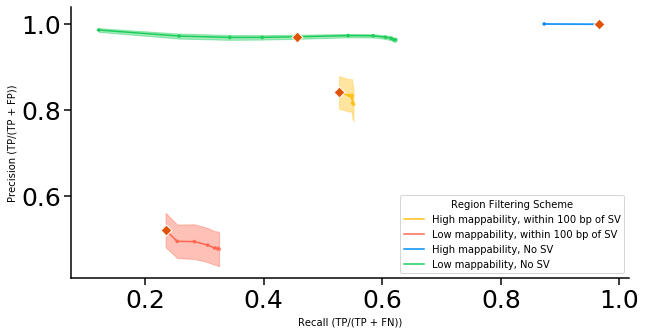

In [71]:
f, axes = plt.subplots(1, 1, figsize=(10,5))

input_DF = HapPy_PR_DF_SNPs_FilteredForFigurePlotting  

### Precision Recall
sns.lineplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN", hue = "Subset", #style = "variantType",
             data = input_DF, ax=axes, legend=False, palette = dictOf_FilterSchemeToColor)

sns.scatterplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN",  hue = "Subset", #style = "variantType",
                data = input_DF, ax=axes, legend=False, s=15, palette = dictOf_FilterSchemeToColor)

for i_scheme in listOf_FilteringSchemes:
    
    input_DF_schemeSubset = input_DF[ input_DF["Subset"] == i_scheme ]
    
    i_color = dictOf_FilterSchemeToColor[i_scheme]
    
    y_i = input_DF_schemeSubset["METRIC.Precision_MEAN"]
    x_i = input_DF_schemeSubset["METRIC.Recall_MEAN"]

    plt.fill_between(x_i, 
                     y_i - input_DF_schemeSubset["METRIC.Precision_SEM"], 
                     y_i + input_DF_schemeSubset["METRIC.Precision_SEM"], interpolate = False, alpha=0.4, color = i_color)

    #plt.fill_betweenx(y_i, x_i - input_DF_schemeSubset["METRIC.Recall_SEM"], x_i + input_DF_schemeSubset["METRIC.Recall_SEM"], alpha=0.2, color = i_color)

plt.legend(title='Region Filtering Scheme', loc='lower right', labels=['High mappability, within 100 bp of SV',
                                                                       'Low mappability, within 100 bp of SV',
                                                                       'High mappability, No SV',
                                                                       'Low mappability, No SV', ])

sns.scatterplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN", color = "#E05307", #style = "variantType", # "#F08043"
                data = HapPy_PR_DF_SNPs[ (HapPy_PR_DF_SNPs["QQ"] == 40 )], ax=axes, marker="D", legend=False, s=60, linewidth=1, zorder=100)

axes.spines["left"].set_linewidth(1.5)
axes.spines["bottom"].set_linewidth(1.5)
sns.despine(ax=axes)
axes.tick_params(width=1.5, length=7)
axes.set_xlabel("Recall (TP/(TP + FN))")
axes.set_ylabel("Precision (TP/(TP + FP))")
axes.tick_params(labelsize= 25)
plt.show()

mkdir: cannot create directory ‘./Illumina_VariantCalling_Eval_Plots/’: File exists


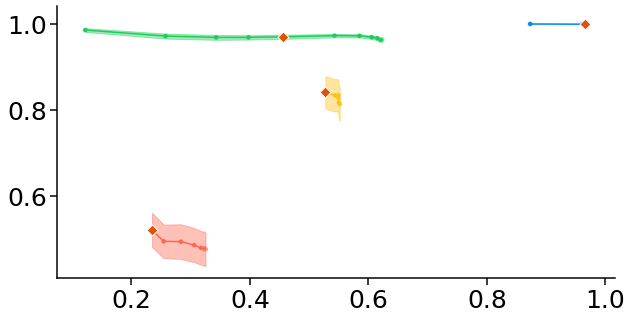

In [72]:
f, axes = plt.subplots(1, 1, figsize=(10,5))

input_DF = HapPy_PR_DF_SNPs_FilteredForFigurePlotting  

### Precision Recall



#plt.errorbar(x = input_DF["METRIC.Recall_MEAN"] , y = input_DF["METRIC.Precision_MEAN"], markersize = 0, elinewidth=1, ls='none',
#            yerr = input_DF["METRIC.Precision_SEM"], color="black", alpha = 1, capsize= 0)


#plt.errorbar(x = input_DF["METRIC.Recall_MEAN"] , y = input_DF["METRIC.Precision_MEAN"], markersize = 0, elinewidth=1, ls='none',
#            xerr = input_DF["METRIC.Recall_SEM"], color="black", alpha = 1, capsize= 0)




sns.lineplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN", hue = "Subset", #style = "variantType",
             data = input_DF, ax=axes, legend=False, palette = dictOf_FilterSchemeToColor)

sns.scatterplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN",  hue = "Subset", #style = "variantType",
                data = input_DF, ax=axes, legend=False, s=25, palette = dictOf_FilterSchemeToColor)



for i_scheme in listOf_FilteringSchemes:
    
    input_DF_schemeSubset = input_DF[ input_DF["Subset"] == i_scheme ]
    
    i_color = dictOf_FilterSchemeToColor[i_scheme]
    
    y_i = input_DF_schemeSubset["METRIC.Precision_MEAN"]
    x_i = input_DF_schemeSubset["METRIC.Recall_MEAN"]

    plt.fill_between(x_i, 
                     y_i - input_DF_schemeSubset["METRIC.Precision_SEM"], 
                     y_i + input_DF_schemeSubset["METRIC.Precision_SEM"], interpolate = False, alpha=0.4, color = i_color)

    #plt.fill_betweenx(y_i, x_i - input_DF_schemeSubset["METRIC.Recall_SEM"], x_i + input_DF_schemeSubset["METRIC.Recall_SEM"], alpha=0.2, color = i_color)





sns.scatterplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN", color = "#E05307", #style = "variantType", # "#F08043"
                data = HapPy_PR_DF_SNPs[ (HapPy_PR_DF_SNPs["QQ"] == 40 )], ax=axes, marker="D", legend=False, s=60, linewidth=1, zorder=100)



#plt.legend(title='Region Filtering Scheme', loc='lower right', labels=['High mappability, within 100 bp of SV',
#                                                                       'Low mappability, within 100 bp of SV',
#                                                                       'High mappability, No SV',
#                                                                       'Low mappability, No SV', ])


axes.spines["left"].set_linewidth(1.5)
axes.spines["bottom"].set_linewidth(1.5)

sns.despine(ax=axes)

axes.tick_params(width=1.5, length=7)



axes.set_xlabel("")
axes.set_ylabel("")


axes.tick_params(labelsize= 25)

!mkdir ./Illumina_VariantCalling_Eval_Plots/

Output_PNG_PATH = "./Illumina_VariantCalling_Eval_Plots/Fig6_VC_Eval_36CI_SNVsOnly_PR_Plots_SVsPMAP_4Categories_MQ_0to40_ForWithSVs_V2.png"       
Output_PDF_PATH = "./Illumina_VariantCalling_Eval_Plots/Fig6_VC_Eval_36CI_SNVsOnly_PR_Plots_SVsPMAP_4Categories_MQ_0to40_ForWithSVs_V2.pdf"       


plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=300)
plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)
plt.show()

mkdir: cannot create directory ‘./Illumina_VariantCalling_Eval_Plots/’: File exists


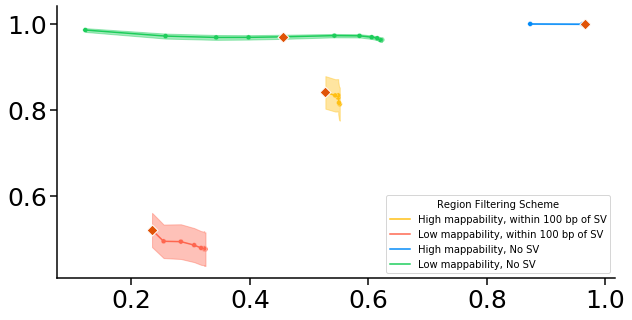

In [73]:
f, axes = plt.subplots(1, 1, figsize=(10,5))

input_DF = HapPy_PR_DF_SNPs_FilteredForFigurePlotting  

### Precision Recall



#plt.errorbar(x = input_DF["METRIC.Recall_MEAN"] , y = input_DF["METRIC.Precision_MEAN"], markersize = 0, elinewidth=1, ls='none',
#            yerr = input_DF["METRIC.Precision_SEM"], color="black", alpha = 1, capsize= 0)


#plt.errorbar(x = input_DF["METRIC.Recall_MEAN"] , y = input_DF["METRIC.Precision_MEAN"], markersize = 0, elinewidth=1, ls='none',
#            xerr = input_DF["METRIC.Recall_SEM"], color="black", alpha = 1, capsize= 0)




sns.lineplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN", hue = "Subset", #style = "variantType",
             data = input_DF, ax=axes, legend=False, palette = dictOf_FilterSchemeToColor)

sns.scatterplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN",  hue = "Subset", #style = "variantType",
                data = input_DF, ax=axes, legend="full", s=25, palette = dictOf_FilterSchemeToColor)



for i_scheme in listOf_FilteringSchemes:
    
    input_DF_schemeSubset = input_DF[ input_DF["Subset"] == i_scheme ]
    
    i_color = dictOf_FilterSchemeToColor[i_scheme]
    
    y_i = input_DF_schemeSubset["METRIC.Precision_MEAN"]
    x_i = input_DF_schemeSubset["METRIC.Recall_MEAN"]

    plt.fill_between(x_i, 
                     y_i - input_DF_schemeSubset["METRIC.Precision_SEM"], 
                     y_i + input_DF_schemeSubset["METRIC.Precision_SEM"], interpolate = False, alpha=0.4, color = i_color)

    #plt.fill_betweenx(y_i, x_i - input_DF_schemeSubset["METRIC.Recall_SEM"], x_i + input_DF_schemeSubset["METRIC.Recall_SEM"], alpha=0.2, color = i_color)





sns.scatterplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN", color = "#E05307", #style = "variantType", # "#F08043"
                data = HapPy_PR_DF_SNPs[ (HapPy_PR_DF_SNPs["QQ"] == 40 )], ax=axes, marker="D", legend=False, s=60, linewidth=1, zorder=100)



plt.legend(title='Region Filtering Scheme', loc='lower right', labels=['High mappability, within 100 bp of SV',
                                                                       'Low mappability, within 100 bp of SV',
                                                                       'High mappability, No SV',
                                                                       'Low mappability, No SV', ])


axes.spines["left"].set_linewidth(1.5)
axes.spines["bottom"].set_linewidth(1.5)

sns.despine(ax=axes)

axes.tick_params(width=1.5, length=7)



axes.set_xlabel("")
axes.set_ylabel("")


axes.tick_params(labelsize= 25)

!mkdir ./Illumina_VariantCalling_Eval_Plots/

Output_PNG_PATH = "./Illumina_VariantCalling_Eval_Plots/Fig6_VC_Eval_36CI_SNVsOnly_PR_Plots_SVsPMAP_4Categories_MQ_0to40_ForWithSVs_V2.WithLegend.png"       
#Output_PDF_PATH = "./Illumina_VariantCalling_Eval_Plots/Fig6_VC_Eval_36CI_SNVsOnly_PR_Plots_SVsPMAP_4Categories_MQ_0to40_ForWithSVs_V2.pdf"       

plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=300)
#plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)
plt.show()

mkdir: cannot create directory ‘./Illumina_VariantCalling_Eval_Plots/’: File exists


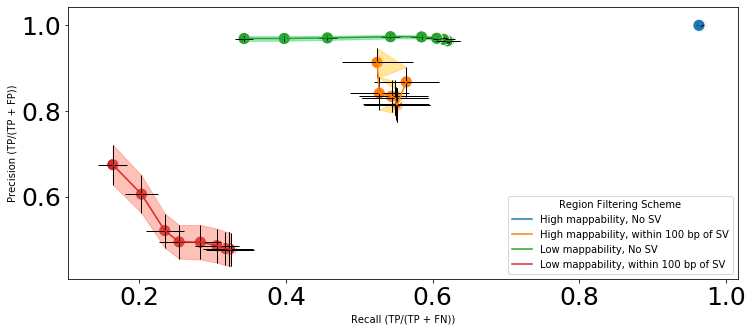

In [74]:
f, axes = plt.subplots(1, 1, figsize=(12,5))

input_DF = HapPy_PR_DF_SNPs_QQ_0to55  

### Precision Recall



plt.errorbar(x = input_DF["METRIC.Recall_MEAN"] , y = input_DF["METRIC.Precision_MEAN"], markersize = 0, elinewidth=1, ls='none',
            yerr = input_DF["METRIC.Precision_SEM"], color="black", alpha = 1, capsize= 0)


plt.errorbar(x = input_DF["METRIC.Recall_MEAN"] , y = input_DF["METRIC.Precision_MEAN"], markersize = 0, elinewidth=1, ls='none',
            xerr = input_DF["METRIC.Recall_SEM"], color="black", alpha = 1, capsize= 0)




sns.lineplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN", hue = "Subset", #style = "variantType",
             data = input_DF, ax=axes, legend=False)

sns.scatterplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN",  hue = "Subset", #style = "variantType",
                data = input_DF, ax=axes, legend="full", s=150)



for i_scheme in listOf_FilteringSchemes:
    
    input_DF_schemeSubset = input_DF[ input_DF["Subset"] == i_scheme ]
    
    i_color = dictOf_FilterSchemeToColor[i_scheme]
    
    y_i = input_DF_schemeSubset["METRIC.Precision_MEAN"]
    x_i = input_DF_schemeSubset["METRIC.Recall_MEAN"]

    plt.fill_between(x_i, 
                     y_i - input_DF_schemeSubset["METRIC.Precision_SEM"], 
                     y_i + input_DF_schemeSubset["METRIC.Precision_SEM"], interpolate = False, alpha=0.4, color = i_color)

    #plt.fill_betweenx(y_i, x_i - input_DF_schemeSubset["METRIC.Recall_SEM"], x_i + input_DF_schemeSubset["METRIC.Recall_SEM"], alpha=0.2, color = i_color)



plt.legend(title='Region Filtering Scheme', loc='lower right', labels=['High mappability, No SV',
                                                                      'High mappability, within 100 bp of SV',
                                                                      'Low mappability, No SV',
                                                                      'Low mappability, within 100 bp of SV',])




axes.set_xlabel("Recall (TP/(TP + FN))")
axes.set_ylabel("Precision (TP/(TP + FP))")


axes.tick_params(labelsize= 25)

!mkdir ./Illumina_VariantCalling_Eval_Plots/

Output_PNG_PATH = "./Illumina_VariantCalling_Eval_Plots/Fig6_VC_Eval_36CI_SNVsOnly_PrecisionRecall_Plots_SVsPMAP_4Categories_MQ_0to50_V2.png"       
Output_PDF_PATH = "./Illumina_VariantCalling_Eval_Plots/Fig6_VC_Eval_36CI_SNVsOnly_PrecisionRecall_Plots_SVsPMAP_4Categories_MQ_0to50_V2.pdf"       


#plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
#plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)
plt.show()

mkdir: cannot create directory ‘./Illumina_VariantCalling_Eval_Plots/’: File exists


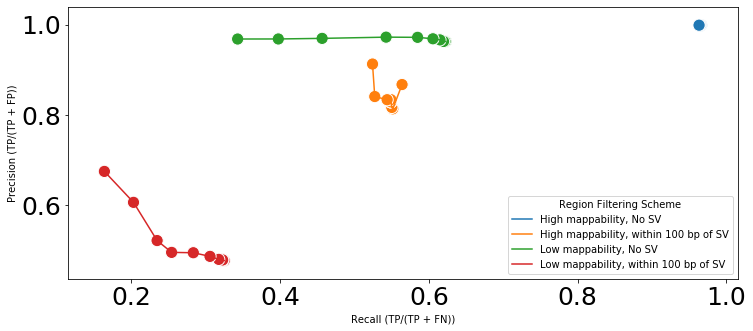

In [75]:
f, axes = plt.subplots(1, 1, figsize=(12,5))

input_DF = HapPy_PR_DF_SNPs_QQ_0to55  

### Precision Recall
sns.lineplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN", hue = "Subset", #style = "variantType",
             data = input_DF, ax=axes, legend=False)

sns.scatterplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN",  hue = "Subset", #style = "variantType",
                data = input_DF, ax=axes, legend="full", s=150)

#axes.set_title("Precision-Recall Curve: Comparing different")
#axes.set_xlabel("TPR (TP/(TP + FN))")
#axes.set_ylabel("PPV (TP/(TP + FP))")
axes.set_xlabel("Recall (TP/(TP + FN))")
axes.set_ylabel("Precision (TP/(TP + FP))")
#axes.set_ylim(0.9, 1.02)
#axes.set_xlim(0.6, 1.02)

axes.tick_params(labelsize= 25)


plt.legend(title='Region Filtering Scheme', loc='lower right', labels=['High mappability, No SV',
                                                                      'High mappability, within 100 bp of SV',
                                                                      'Low mappability, No SV',
                                                                      'Low mappability, within 100 bp of SV',])



!mkdir ./Illumina_VariantCalling_Eval_Plots/

Output_PNG_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_36CI_SNVsOnly_PrecisionRecall_Plots_SVsPMAP_4Categories_MQ_0to55_V2.png"       
Output_PDF_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_36CI_SNVsOnly_PrecisionRecall_Plots_SVsPMAP_4Categories_MQ_0to55_V2.pdf"       

#plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
#plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)
plt.show()

In [76]:
HapPy_PR_DF_SNPs["Subset"].value_counts()

HighPmap_WiSV    61
LowPmap_WiSV     61
HighPmap_NoSV    61
LowPmap_NoSV     61
Name: Subset, dtype: int64

mkdir: cannot create directory ‘./Illumina_VariantCalling_Eval_Plots/’: File exists


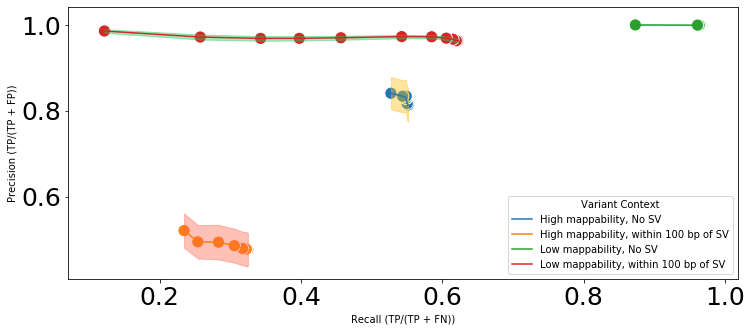

In [77]:
f, axes = plt.subplots(1, 1, figsize=(12,5))

input_DF = HapPy_PR_DF_SNPs_FilteredForFigurePlotting  

### Precision Recall



sns.lineplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN", hue = "Subset", #style = "variantType",
             data = input_DF, ax=axes, legend=False)

sns.scatterplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN",  hue = "Subset", #style = "variantType",
                data = input_DF, ax=axes, legend="full", s=150)



for i_scheme in listOf_FilteringSchemes:
    
    input_DF_schemeSubset = input_DF[ input_DF["Subset"] == i_scheme ]
    
    i_color = dictOf_FilterSchemeToColor[i_scheme]
    
    y_i = input_DF_schemeSubset["METRIC.Precision_MEAN"]
    x_i = input_DF_schemeSubset["METRIC.Recall_MEAN"]

    plt.fill_between(x_i, 
                     y_i - input_DF_schemeSubset["METRIC.Precision_SEM"], 
                     y_i + input_DF_schemeSubset["METRIC.Precision_SEM"], alpha=0.4, color = i_color)

    #plt.fill_betweenx(y_i, x_i - input_DF_schemeSubset["METRIC.Recall_SEM"], x_i + input_DF_schemeSubset["METRIC.Recall_SEM"], alpha=0.2, color = i_color)



plt.legend(title='Variant Context', loc='lower right', labels=['High mappability, No SV',
                                                                      'High mappability, within 100 bp of SV',
                                                                      'Low mappability, No SV',
                                                                      'Low mappability, within 100 bp of SV',])




axes.set_xlabel("Recall (TP/(TP + FN))")
axes.set_ylabel("Precision (TP/(TP + FP))")


axes.tick_params(labelsize= 25)

!mkdir ./Illumina_VariantCalling_Eval_Plots/

Output_PNG_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_36CI_SNVsOnly_PrecisionRecall_Plots_SVsPMAP_4Categories_MQ_0to60_V2.png"       
Output_PDF_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_36CI_SNVsOnly_PrecisionRecall_Plots_SVsPMAP_4Categories_MQ_0to60_V2.pdf"       

plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)
plt.show()

mkdir: cannot create directory ‘./Illumina_VariantCalling_Eval_Plots/’: File exists


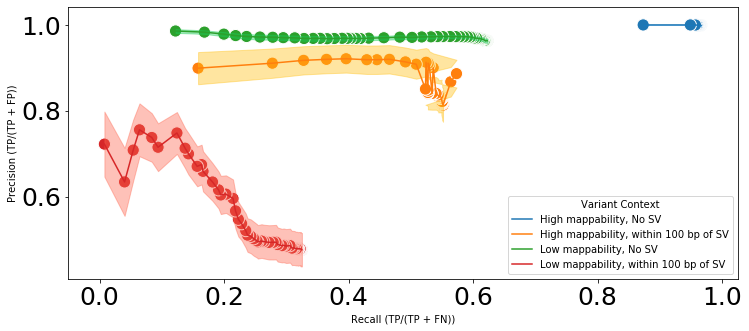

In [78]:
f, axes = plt.subplots(1, 1, figsize=(12,5))

input_DF = HapPy_PR_DF_SNPs  

### Precision Recall



sns.lineplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN", hue = "Subset", #style = "variantType",
             data = input_DF, ax=axes, legend=False)

sns.scatterplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN",  hue = "Subset", #style = "variantType",
                data = input_DF, ax=axes, legend="full", s=150)



for i_scheme in listOf_FilteringSchemes:
    
    input_DF_schemeSubset = input_DF[ input_DF["Subset"] == i_scheme ]
    
    i_color = dictOf_FilterSchemeToColor[i_scheme]
    
    y_i = input_DF_schemeSubset["METRIC.Precision_MEAN"]
    x_i = input_DF_schemeSubset["METRIC.Recall_MEAN"]

    plt.fill_between(x_i, 
                     y_i - input_DF_schemeSubset["METRIC.Precision_SEM"], 
                     y_i + input_DF_schemeSubset["METRIC.Precision_SEM"], alpha=0.4, color = i_color)

    #plt.fill_betweenx(y_i, x_i - input_DF_schemeSubset["METRIC.Recall_SEM"], x_i + input_DF_schemeSubset["METRIC.Recall_SEM"], alpha=0.2, color = i_color)



plt.legend(title='Variant Context', loc='lower right', labels=['High mappability, No SV',
                                                                      'High mappability, within 100 bp of SV',
                                                                      'Low mappability, No SV',
                                                                      'Low mappability, within 100 bp of SV',])




axes.set_xlabel("Recall (TP/(TP + FN))")
axes.set_ylabel("Precision (TP/(TP + FP))")


axes.tick_params(labelsize= 25)

!mkdir ./Illumina_VariantCalling_Eval_Plots/

Output_PNG_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_36CI_SNVsOnly_PrecisionRecall_Plots_SVsPMAP_4Categories_MQ_0to60_V2.png"       
Output_PDF_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_36CI_SNVsOnly_PrecisionRecall_Plots_SVsPMAP_4Categories_MQ_0to60_V2.pdf"       

#plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
#plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)
plt.show()

mkdir: cannot create directory ‘./Illumina_VariantCalling_Eval_Plots/’: File exists


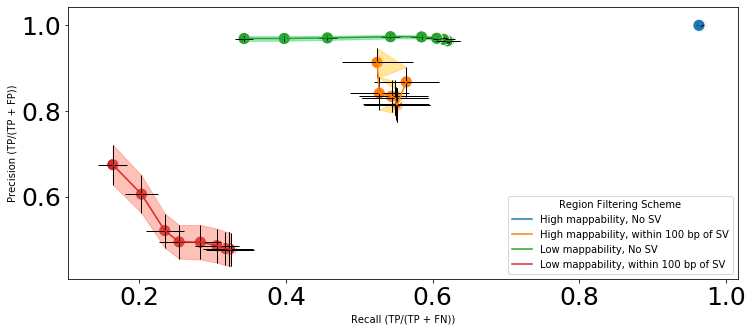

In [79]:
f, axes = plt.subplots(1, 1, figsize=(12,5))

input_DF = HapPy_PR_DF_SNPs_QQ_0to55  

### Precision Recall



plt.errorbar(x = input_DF["METRIC.Recall_MEAN"] , y = input_DF["METRIC.Precision_MEAN"], markersize = 0, elinewidth=1, ls='none',
            yerr = input_DF["METRIC.Precision_SEM"], color="black", alpha = 1, capsize= 0)


plt.errorbar(x = input_DF["METRIC.Recall_MEAN"] , y = input_DF["METRIC.Precision_MEAN"], markersize = 0, elinewidth=1, ls='none',
            xerr = input_DF["METRIC.Recall_SEM"], color="black", alpha = 1, capsize= 0)




sns.lineplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN", hue = "Subset", #style = "variantType",
             data = input_DF, ax=axes, legend=False)

sns.scatterplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN",  hue = "Subset", #style = "variantType",
                data = input_DF, ax=axes, legend="full", s=150)



for i_scheme in listOf_FilteringSchemes:
    
    input_DF_schemeSubset = input_DF[ input_DF["Subset"] == i_scheme ]
    
    i_color = dictOf_FilterSchemeToColor[i_scheme]
    
    y_i = input_DF_schemeSubset["METRIC.Precision_MEAN"]
    x_i = input_DF_schemeSubset["METRIC.Recall_MEAN"]

    plt.fill_between(x_i, 
                     y_i - input_DF_schemeSubset["METRIC.Precision_SEM"], 
                     y_i + input_DF_schemeSubset["METRIC.Precision_SEM"], interpolate = False, alpha=0.4, color = i_color)

    #plt.fill_betweenx(y_i, x_i - input_DF_schemeSubset["METRIC.Recall_SEM"], x_i + input_DF_schemeSubset["METRIC.Recall_SEM"], alpha=0.2, color = i_color)



plt.legend(title='Region Filtering Scheme', loc='lower right', labels=['High mappability, No SV',
                                                                      'High mappability, within 100 bp of SV',
                                                                      'Low mappability, No SV',
                                                                      'Low mappability, within 100 bp of SV',])




axes.set_xlabel("Recall (TP/(TP + FN))")
axes.set_ylabel("Precision (TP/(TP + FP))")


axes.tick_params(labelsize= 25)

!mkdir ./Illumina_VariantCalling_Eval_Plots/

Output_PNG_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_36CI_SNVsOnly_PrecisionRecall_Plots_SVsPMAP_4Categories_MQ_0to50_V2.png"       
Output_PDF_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_36CI_SNVsOnly_PrecisionRecall_Plots_SVsPMAP_4Categories_MQ_0to50_V2.pdf"       


#plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
#plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)
plt.show()

## Output Figure 6: SNS VC Performance stratified by SV and Pmap of surrounding sequence

- No Legend
- Despine plot (w/ sns function)
- Change tick aspects

mkdir: cannot create directory ‘./Illumina_VariantCalling_Eval_Plots/’: File exists


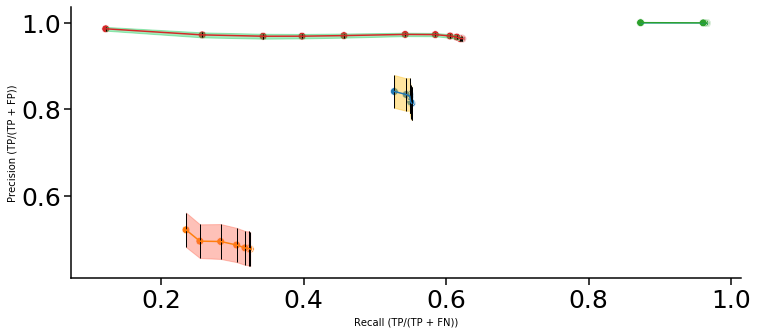

In [80]:
f, axes = plt.subplots(1, 1, figsize=(12,5))

input_DF = HapPy_PR_DF_SNPs_FilteredForFigurePlotting  

### Precision Recall



plt.errorbar(x = input_DF["METRIC.Recall_MEAN"] , y = input_DF["METRIC.Precision_MEAN"], markersize = 0, elinewidth=1, ls='none',
            yerr = input_DF["METRIC.Precision_SEM"], color="black", alpha = 1, capsize= 0)


#plt.errorbar(x = input_DF["METRIC.Recall_MEAN"] , y = input_DF["METRIC.Precision_MEAN"], markersize = 0, elinewidth=1, ls='none',
#            xerr = input_DF["METRIC.Recall_SEM"], color="black", alpha = 1, capsize= 0)




sns.lineplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN", hue = "Subset", #style = "variantType",
             data = input_DF, ax=axes, legend=False)

sns.scatterplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN",  hue = "Subset", #style = "variantType",
                data = input_DF, ax=axes, legend=False, s=60)



for i_scheme in listOf_FilteringSchemes:
    
    input_DF_schemeSubset = input_DF[ input_DF["Subset"] == i_scheme ]
    
    i_color = dictOf_FilterSchemeToColor[i_scheme]
    
    y_i = input_DF_schemeSubset["METRIC.Precision_MEAN"]
    x_i = input_DF_schemeSubset["METRIC.Recall_MEAN"]

    plt.fill_between(x_i, 
                     y_i - input_DF_schemeSubset["METRIC.Precision_SEM"], 
                     y_i + input_DF_schemeSubset["METRIC.Precision_SEM"], interpolate = False, alpha=0.4, color = i_color)

    #plt.fill_betweenx(y_i, x_i - input_DF_schemeSubset["METRIC.Recall_SEM"], x_i + input_DF_schemeSubset["METRIC.Recall_SEM"], alpha=0.2, color = i_color)



#plt.legend(title='Region Filtering Scheme', loc='lower right', labels=['High mappability, No SV',
#                                                                      'High mappability, within 100 bp of SV',
#                                                                      'Low mappability, No SV',
#                                                                      'Low mappability, within 100 bp of SV',])


axes.spines["left"].set_linewidth(1.5)
axes.spines["bottom"].set_linewidth(1.5)

sns.despine(ax=axes)

axes.tick_params(width=1.5, length=7)



axes.set_xlabel("Recall (TP/(TP + FN))")
axes.set_ylabel("Precision (TP/(TP + FP))")


axes.tick_params(labelsize= 25)

!mkdir ./Illumina_VariantCalling_Eval_Plots/

Output_PNG_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_36CI_SNVsOnly_PrecisionRecall_Plots_SVsPMAP_4Categories_MQ_0to50_V2.png"       
Output_PDF_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_36CI_SNVsOnly_PrecisionRecall_Plots_SVsPMAP_4Categories_MQ_0to50_V2.pdf"       


#plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
#plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)
plt.show()

mkdir: cannot create directory ‘./Illumina_VariantCalling_Eval_Plots/’: File exists


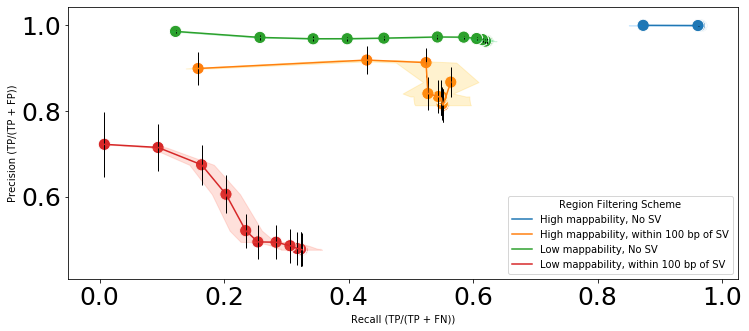

In [81]:
f, axes = plt.subplots(1, 1, figsize=(12,5))

input_DF = HapPy_PR_DF_SNPs_QQ_0to60  
#input_DF = HapPy_PR_DF_SNPs

### Precision Recall



plt.errorbar(x = input_DF["METRIC.Recall_MEAN"] , y = input_DF["METRIC.Precision_MEAN"], markersize = 0, elinewidth=1, ls='none',
            yerr = input_DF["METRIC.Precision_SEM"], color="black", alpha = 1, capsize= 0)

#plt.errorbar(x = HapPy_PR_DF_SNPs["METRIC.Recall_MEAN"] , y = HapPy_PR_DF_SNPs["METRIC.Precision_MEAN"], markersize = 0, elinewidth=1, ls='none',
#            xerr = HapPy_PR_DF_SNPs["METRIC.Recall_SEM"], color="black", alpha = 1, capsize= 0)




sns.lineplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN", hue = "Subset", #style = "variantType",
             data = input_DF, ax=axes, legend=False)

sns.scatterplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN",  hue = "Subset", #style = "variantType",
                data = input_DF, ax=axes, legend="full", s=150)



for i_scheme in listOf_FilteringSchemes:
    
    input_DF_schemeSubset = input_DF[ input_DF["Subset"] == i_scheme ]
    
    i_color = dictOf_FilterSchemeToColor[i_scheme]
    
    y_i = input_DF_schemeSubset["METRIC.Precision_MEAN"]
    x_i = input_DF_schemeSubset["METRIC.Recall_MEAN"]

    #plt.fill_between(x_i, 
    #                 y_i - input_DF_schemeSubset["METRIC.Precision_SEM"], 
    #                 y_i + input_DF_schemeSubset["METRIC.Precision_SEM"], alpha=0.4, color = i_color)

    plt.fill_betweenx(y_i, x_i - input_DF_schemeSubset["METRIC.Recall_SEM"], x_i + input_DF_schemeSubset["METRIC.Recall_SEM"], alpha=0.2, color = i_color)



plt.legend(title='Region Filtering Scheme', loc='lower right', labels=['High mappability, No SV',
                                                                      'High mappability, within 100 bp of SV',
                                                                      'Low mappability, No SV',
                                                                      'Low mappability, within 100 bp of SV',])




axes.set_xlabel("Recall (TP/(TP + FN))")
axes.set_ylabel("Precision (TP/(TP + FP))")


axes.tick_params(labelsize= 25)

!mkdir ./Illumina_VariantCalling_Eval_Plots/

Output_PNG_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_36CI_SNVsOnly_PrecisionRecall_Plots_SVsPMAP_4Categories_MQ_0to60_V2_RecallSEM_Shaded_Precision_ErrorBars.png"       
Output_PDF_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_36CI_SNVsOnly_PrecisionRecall_Plots_SVsPMAP_4Categories_MQ_0to60_V2_RecallSEM_Shaded_Precision_ErrorBars.pdf"       

#plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
#plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)
plt.show()

In [82]:
input_DF.head()

,QQ,RegionFilteringScheme,variantType,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,Count_Col_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM,Count_Col_SEM
4,1,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_NoSV,0.966014,0.998741,0.003636,0.981994,1167.833333,38.250000,1167.722222,1.527778,4.750000,1,0.003340,0.000338,0.000926,0.001706,79.982642,3.429419,79.977910,0.424425,1.209339,0.0
5,1,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,0.551568,0.813448,0.094876,0.648590,8.068966,7.586207,8.068966,1.689655,1.551724,1,0.044833,0.038524,0.020764,0.034057,0.806273,1.169730,0.806273,0.358237,0.396368,0.0
6,1,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_NoSV,0.622757,0.962821,0.030070,0.752105,149.194444,91.916667,144.388889,5.861111,5.611111,1,0.014656,0.004611,0.007585,0.010770,7.989559,6.691664,7.994966,0.802924,1.496704,0.0
7,1,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_WiSV,0.324958,0.476429,0.106717,0.383075,10.111111,21.027778,10.111111,10.416667,2.111111,1,0.032136,0.039004,0.022086,0.028420,1.272903,2.227350,1.272903,1.142522,0.429535,0.0
20,5,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_NoSV,0.966014,0.998741,0.003600,0.981994,1167.833333,38.250000,1167.722222,1.527778,4.694444,1,0.003340,0.000338,0.000919,0.001706,79.982642,3.429419,79.977910,0.424425,1.199748,0.0


mkdir: cannot create directory ‘./Illumina_VariantCalling_Eval_Plots/’: File exists


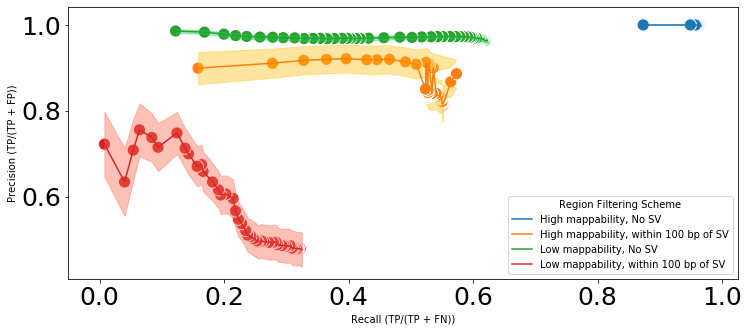

In [83]:
f, axes = plt.subplots(1, 1, figsize=(12,5))

input_DF = HapPy_PR_DF_SNPs  
#input_DF = HapPy_PR_DF_SNPs

### Precision Recall



#plt.errorbar(x = input_DF["METRIC.Recall_MEAN"] , y = input_DF["METRIC.Precision_MEAN"], markersize = 0, elinewidth=1, ls='none',
#            yerr = input_DF["METRIC.Precision_SEM"], color="black", alpha = 1, capsize= 0)

#plt.errorbar(x = HapPy_PR_DF_SNPs["METRIC.Recall_MEAN"] , y = HapPy_PR_DF_SNPs["METRIC.Precision_MEAN"], markersize = 0, elinewidth=1, ls='none',
#            xerr = HapPy_PR_DF_SNPs["METRIC.Recall_SEM"], color="black", alpha = 1, capsize= 0)




sns.lineplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN", hue = "Subset", #style = "variantType",
             data = input_DF, ax=axes, legend=False)

sns.scatterplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN",  hue = "Subset", #style = "variantType",
                data = input_DF, ax=axes, legend="full", s=150)



for i_scheme in listOf_FilteringSchemes:
    
    input_DF_schemeSubset = input_DF[ input_DF["Subset"] == i_scheme ]
    
    i_color = dictOf_FilterSchemeToColor[i_scheme]
    
    y_i = input_DF_schemeSubset["METRIC.Precision_MEAN"]
    x_i = input_DF_schemeSubset["METRIC.Recall_MEAN"]

    plt.fill_between(x_i, 
                     y_i - input_DF_schemeSubset["METRIC.Precision_SEM"], 
                     y_i + input_DF_schemeSubset["METRIC.Precision_SEM"], alpha=0.4, color = i_color)

    #plt.fill_betweenx(y_i, x_i - input_DF_schemeSubset["METRIC.Recall_SEM"], x_i + input_DF_schemeSubset["METRIC.Recall_SEM"], alpha=0.2, color = i_color)



plt.legend(title='Region Filtering Scheme', loc='lower right', labels=['High mappability, No SV',
                                                                      'High mappability, within 100 bp of SV',
                                                                      'Low mappability, No SV',
                                                                      'Low mappability, within 100 bp of SV',])




axes.set_xlabel("Recall (TP/(TP + FN))")
axes.set_ylabel("Precision (TP/(TP + FP))")


axes.tick_params(labelsize= 25)

!mkdir ./Illumina_VariantCalling_Eval_Plots/

Output_PNG_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_36CI_SNVsOnly_PrecisionRecall_Plots_SVsPMAP_4Categories_MQ_0to60_V2_RecallSEM_Shaded_Precision_ErrorBars.png"       
Output_PDF_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_36CI_SNVsOnly_PrecisionRecall_Plots_SVsPMAP_4Categories_MQ_0to60_V2_RecallSEM_Shaded_Precision_ErrorBars.pdf"       

#plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
#plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)
plt.show()

In [84]:
HapPy_PR_DF_SNPs.head(3)

,QQ,RegionFilteringScheme,variantType,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,Count_Col_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM,Count_Col_SEM
0,0,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_NoSV,0.966014,0.998741,0.003636,0.981994,1167.833333,38.250000,1167.722222,1.527778,4.750000,1,0.003340,0.000338,0.000926,0.001706,79.982642,3.429419,79.977910,0.424425,1.209339,0.0
1,0,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,0.551568,0.813448,0.094876,0.648590,8.068966,7.586207,8.068966,1.689655,1.551724,1,0.044833,0.038524,0.020764,0.034057,0.806273,1.169730,0.806273,0.358237,0.396368,0.0
2,0,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_NoSV,0.622757,0.962821,0.030070,0.752105,149.194444,91.916667,144.388889,5.861111,5.611111,1,0.014656,0.004611,0.007585,0.010770,7.989559,6.691664,7.994966,0.802924,1.496704,0.0


mkdir: cannot create directory ‘./Illumina_VariantCalling_Eval_Plots/’: File exists


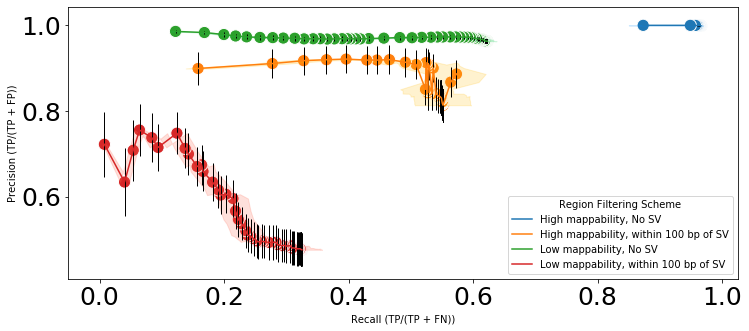

In [85]:
f, axes = plt.subplots(1, 1, figsize=(12,5))

input_DF = HapPy_PR_DF_SNPs  
#input_DF = HapPy_PR_DF_SNPs

### Precision Recall



plt.errorbar(x = input_DF["METRIC.Recall_MEAN"] , y = input_DF["METRIC.Precision_MEAN"], markersize = 0, elinewidth=1, ls='none',
            yerr = input_DF["METRIC.Precision_SEM"], color="black", alpha = 1, capsize= 0)

#plt.errorbar(x = HapPy_PR_DF_SNPs["METRIC.Recall_MEAN"] , y = HapPy_PR_DF_SNPs["METRIC.Precision_MEAN"], markersize = 0, elinewidth=1, ls='none',
#            xerr = HapPy_PR_DF_SNPs["METRIC.Recall_SEM"], color="black", alpha = 1, capsize= 0)




sns.lineplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN", hue = "Subset", #style = "variantType",
             data = input_DF, ax=axes, legend=False)

sns.scatterplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN",  hue = "Subset", #style = "variantType",
                data = input_DF, ax=axes, legend="full", s=150)



for i_scheme in listOf_FilteringSchemes:
    
    input_DF_schemeSubset = input_DF[ input_DF["Subset"] == i_scheme ]
    
    i_color = dictOf_FilterSchemeToColor[i_scheme]
    
    y_i = input_DF_schemeSubset["METRIC.Precision_MEAN"]
    x_i = input_DF_schemeSubset["METRIC.Recall_MEAN"]

    #plt.fill_between(x_i, 
    #                 y_i - input_DF_schemeSubset["METRIC.Precision_SEM"], 
    #                 y_i + input_DF_schemeSubset["METRIC.Precision_SEM"], alpha=0.4, color = i_color)

    plt.fill_betweenx(y_i, x_i - input_DF_schemeSubset["METRIC.Recall_SEM"], x_i + input_DF_schemeSubset["METRIC.Recall_SEM"], alpha=0.2, color = i_color)



plt.legend(title='Region Filtering Scheme', loc='lower right', labels=['High mappability, No SV',
                                                                      'High mappability, within 100 bp of SV',
                                                                      'Low mappability, No SV',
                                                                      'Low mappability, within 100 bp of SV',])




axes.set_xlabel("Recall (TP/(TP + FN))")
axes.set_ylabel("Precision (TP/(TP + FP))")


axes.tick_params(labelsize= 25)

!mkdir ./Illumina_VariantCalling_Eval_Plots/

Output_PNG_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_36CI_SNVsOnly_PrecisionRecall_Plots_SVsPMAP_4Categories_MQ_0to60_V2_RecallSEM_Shaded_Precision_ErrorBars.png"       
Output_PDF_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_36CI_SNVsOnly_PrecisionRecall_Plots_SVsPMAP_4Categories_MQ_0to60_V2_RecallSEM_Shaded_Precision_ErrorBars.pdf"       

#plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
#plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)
plt.show()

mkdir: cannot create directory ‘./Illumina_VariantCalling_Eval_Plots/’: File exists


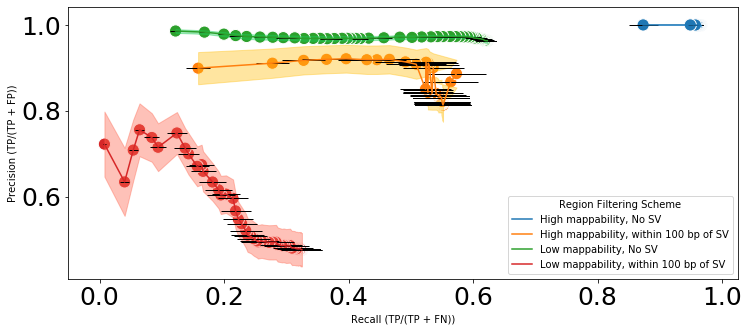

In [86]:
f, axes = plt.subplots(1, 1, figsize=(12,5))

input_DF = HapPy_PR_DF_SNPs  
#input_DF = HapPy_PR_DF_SNPs

### Precision Recall



#plt.errorbar(x = input_DF["METRIC.Recall_MEAN"] , y = input_DF["METRIC.Precision_MEAN"], markersize = 0, elinewidth=1, ls='none',
#            yerr = input_DF["METRIC.Precision_SEM"], color="black", alpha = 1, capsize= 0)

plt.errorbar(x = HapPy_PR_DF_SNPs["METRIC.Recall_MEAN"] , y = HapPy_PR_DF_SNPs["METRIC.Precision_MEAN"], markersize = 0, elinewidth=1, ls='none',
            xerr = HapPy_PR_DF_SNPs["METRIC.Recall_SEM"], color="black", alpha = 1, capsize= 0)




sns.lineplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN", hue = "Subset", #style = "variantType",
             data = input_DF, ax=axes, legend=False)

sns.scatterplot(x="METRIC.Recall_MEAN", y="METRIC.Precision_MEAN",  hue = "Subset", #style = "variantType",
                data = input_DF, ax=axes, legend="full", s=150)



for i_scheme in listOf_FilteringSchemes:
    
    input_DF_schemeSubset = input_DF[ input_DF["Subset"] == i_scheme ]
    
    i_color = dictOf_FilterSchemeToColor[i_scheme]
    
    y_i = input_DF_schemeSubset["METRIC.Precision_MEAN"]
    x_i = input_DF_schemeSubset["METRIC.Recall_MEAN"]

    plt.fill_between(x_i, 
                     y_i - input_DF_schemeSubset["METRIC.Precision_SEM"], 
                     y_i + input_DF_schemeSubset["METRIC.Precision_SEM"], alpha=0.4, color = i_color)

    #plt.fill_betweenx(y_i, x_i - input_DF_schemeSubset["METRIC.Recall_SEM"], x_i + input_DF_schemeSubset["METRIC.Recall_SEM"], alpha=0.2, color = i_color)



plt.legend(title='Region Filtering Scheme', loc='lower right', labels=['High mappability, No SV',
                                                                      'High mappability, within 100 bp of SV',
                                                                      'Low mappability, No SV',
                                                                      'Low mappability, within 100 bp of SV',])




axes.set_xlabel("Recall (TP/(TP + FN))")
axes.set_ylabel("Precision (TP/(TP + FP))")


axes.tick_params(labelsize= 25)

!mkdir ./Illumina_VariantCalling_Eval_Plots/

Output_PNG_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_36CI_SNVsOnly_PrecisionRecall_Plots_SVsPMAP_4Categories_MQ_0to60_V2_RecallSEM_Shaded_Precision_ErrorBars.png"       
Output_PDF_PATH = "./Illumina_VariantCalling_Eval_Plots/VC_Eval_36CI_SNVsOnly_PrecisionRecall_Plots_SVsPMAP_4Categories_MQ_0to60_V2_RecallSEM_Shaded_Precision_ErrorBars.pdf"       

#plt.savefig(Output_PNG_PATH, bbox_inches='tight', dpi=125)
#plt.savefig(Output_PDF_PATH, bbox_inches='tight', transparent=True)
plt.show()

## How many variants total and how many FPs are within each category?

In [87]:
HapPy_PR_DF[ (HapPy_PR_DF["QQ"] == 1 ) &   (HapPy_PR_DF["Subset"] == "HighPmap_NoSV" )   ]

,QQ,RegionFilteringScheme,variantType,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,Count_Col_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM,Count_Col_SEM
4,1,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_NoSV,0.966014,0.998741,0.003636,0.981994,1167.833333,38.25,1167.722222,1.527778,4.75,1,0.00334,0.000338,0.000926,0.001706,79.982642,3.429419,79.97791,0.424425,1.209339,0.0


In [88]:
HapPy_PR_DF[ (HapPy_PR_DF["QQ"] == 1 ) &   (HapPy_PR_DF["Subset"] == "HighPmap_NoSV" )   ].shape

(1, 24)

In [89]:
HapPy_PR_DF.head()

,QQ,RegionFilteringScheme,variantType,Subset,METRIC.Recall_MEAN,METRIC.Precision_MEAN,METRIC.Frac_NA_MEAN,METRIC.F1_Score_MEAN,TRUTH.TP_MEAN,TRUTH.FN_MEAN,QUERY.TP_MEAN,QUERY.FP_MEAN,QUERY.UNK_MEAN,Count_Col_MEAN,METRIC.Recall_SEM,METRIC.Precision_SEM,METRIC.Frac_NA_SEM,METRIC.F1_Score_SEM,TRUTH.TP_SEM,TRUTH.FN_SEM,QUERY.TP_SEM,QUERY.FP_SEM,QUERY.UNK_SEM,Count_Col_SEM
0,0,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_NoSV,0.966014,0.998741,0.003636,0.981994,1167.833333,38.250000,1167.722222,1.527778,4.750000,1,0.003340,0.000338,0.000926,0.001706,79.982642,3.429419,79.977910,0.424425,1.209339,0.0
1,0,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_WiSV,0.551568,0.813448,0.094876,0.648590,8.068966,7.586207,8.068966,1.689655,1.551724,1,0.044833,0.038524,0.020764,0.034057,0.806273,1.169730,0.806273,0.358237,0.396368,0.0
2,0,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_NoSV,0.622757,0.962821,0.030070,0.752105,149.194444,91.916667,144.388889,5.861111,5.611111,1,0.014656,0.004611,0.007585,0.010770,7.989559,6.691664,7.994966,0.802924,1.496704,0.0
3,0,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,LowPmap_WiSV,0.324958,0.476429,0.106717,0.383075,10.111111,21.027778,10.111111,10.416667,2.111111,1,0.032136,0.039004,0.022086,0.028420,1.272903,2.227350,1.272903,1.142522,0.429535,0.0
4,1,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,HighPmap_NoSV,0.966014,0.998741,0.003636,0.981994,1167.833333,38.250000,1167.722222,1.527778,4.750000,1,0.003340,0.000338,0.000926,0.001706,79.982642,3.429419,79.977910,0.424425,1.209339,0.0


In [90]:
HapPy_PR_DF["Subset"].value_counts()

HighPmap_WiSV    61
LowPmap_WiSV     61
HighPmap_NoSV    61
LowPmap_NoSV     61
Name: Subset, dtype: int64

### How many FPs total are there per "subtype"?

In [91]:
HapPy_PR_DF_Indiv_MQ1 = HapPy_PR_DF_IndividualCurves[ (HapPy_PR_DF_IndividualCurves["QQ"] == 30 )]

In [92]:
HapPy_PR_DF_Indiv_MQ1[ (HapPy_PR_DF_Indiv_MQ1["Subset"] == "HighPmap_NoSV" )].shape

(36, 20)

In [93]:
HapPy_PR_DF_Indiv_MQ1.head()

,Type,Subtype,Subset,Filter,Genotype,QQ.Field,QQ,METRIC.Recall,METRIC.Precision,METRIC.Frac_NA,METRIC.F1_Score,TRUTH.TP,TRUTH.FN,QUERY.TP,QUERY.FP,QUERY.UNK,SampleID,RegionFilteringScheme,variantType,Count_Col
30,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,30,0.949468,1.000000,0.0,0.974079,714.0,38.0,714.0,0.0,0.0,M0011368_9,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,1
30,SNP,*,HighPmap_WiSV,PASS,*,INFO.MQ,30,0.000000,0.000000,0.0,NaN,0.0,8.0,0.0,0.0,0.0,M0011368_9,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,1
30,SNP,*,LowPmap_WiSV,PASS,*,INFO.MQ,30,0.173913,0.750000,0.2,0.282353,4.0,19.0,3.0,1.0,1.0,M0011368_9,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,1
30,SNP,*,LowPmap_NoSV,PASS,*,INFO.MQ,30,0.581699,0.988095,0.0,0.732292,89.0,64.0,83.0,1.0,0.0,M0011368_9,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,1
30,SNP,*,HighPmap_NoSV,PASS,*,INFO.MQ,30,0.918771,0.998805,0.0,0.957118,837.0,74.0,836.0,1.0,0.0,M0014888_3,MM2vsPilon_NoneRemoved_Stratified_By_Pmap_and_...,ALL,1


### 1) HighPmap_NoSV

In [94]:
HapPy_PR_DF_Indiv_MQ1[ (HapPy_PR_DF_Indiv_MQ1["Subset"] == "HighPmap_NoSV" )]["QUERY.TP"].sum()

42025.0

In [95]:
HapPy_PR_DF_Indiv_MQ1[ (HapPy_PR_DF_Indiv_MQ1["Subset"] == "HighPmap_NoSV" )]["QUERY.FP"].sum()

45.0

In [96]:
HapPy_PR_DF_Indiv_MQ1[ (HapPy_PR_DF_Indiv_MQ1["Subset"] == "HighPmap_NoSV" )]["QUERY.UNK"].sum()

137.0

In [97]:
41602 + 35 

41637

### 2) LowPmap_NoSV

In [98]:
HapPy_PR_DF_Indiv_MQ1[ (HapPy_PR_DF_Indiv_MQ1["Subset"] == "LowPmap_NoSV" )]["QUERY.TP"].sum()

4874.0

In [99]:
HapPy_PR_DF_Indiv_MQ1[ (HapPy_PR_DF_Indiv_MQ1["Subset"] == "LowPmap_NoSV" )]["QUERY.FP"].sum()

141.0

In [100]:
HapPy_PR_DF_Indiv_MQ1[ (HapPy_PR_DF_Indiv_MQ1["Subset"] == "LowPmap_NoSV" )]["QUERY.UNK"].sum()

163.0

In [101]:
4893 + 306

5199

In [102]:
Num_FP / (Num_FP + Num_TP) 

NameError: name 'Num_FP' is not defined

### 3) HighPmap_WiSV

In [ ]:
Num_TP = HapPy_PR_DF_Indiv_MQ1[ (HapPy_PR_DF_Indiv_MQ1["Subset"] == "HighPmap_WiSV" )]["QUERY.TP"].sum()
Num_TP

In [ ]:
Num_FP = HapPy_PR_DF_Indiv_MQ1[ (HapPy_PR_DF_Indiv_MQ1["Subset"] == "HighPmap_WiSV" )]["QUERY.FP"].sum()
Num_FP

In [ ]:
HapPy_PR_DF_Indiv_MQ1[ (HapPy_PR_DF_Indiv_MQ1["Subset"] == "HighPmap_WiSV" )]["QUERY.UNK"].sum()

In [ ]:
364 + 40

### 4) LowPmap_WiSV

In [ ]:
Num_TP = HapPy_PR_DF_Indiv_MQ1[ (HapPy_PR_DF_Indiv_MQ1["Subset"] == "LowPmap_WiSV" )]["QUERY.TP"].sum()
Num_TP

In [ ]:
Num_FP = HapPy_PR_DF_Indiv_MQ1[ (HapPy_PR_DF_Indiv_MQ1["Subset"] == "LowPmap_WiSV" )]["QUERY.FP"].sum()
Num_FP

In [ ]:
HapPy_PR_DF_Indiv_MQ1[ (HapPy_PR_DF_Indiv_MQ1["Subset"] == "LowPmap_WiSV" )]["QUERY.UNK"].sum()

In [ ]:
311 + 161

In [ ]:
41637 + 5199 + 404 + 472

In [ ]:
41637 / 47712

In [ ]:
5199 / 47712

In [ ]:
404 / 47712

In [ ]:
472 / 47712

In [ ]:
Num_FP / (Num_FP + Num_TP) 

In [ ]:
#i_ALL_PASS_SNP_DF_Subtype_FF = parse_HapPy_Benchmark_DF_and_FFILL_And_Add0_UpTo60QQ(i_ALL_PASS_SNP_DF_HighPmap_WiSV)

In [ ]:
#i_ALL_PASS_SNP_DF_HighPmap_WiSV.tail()

In [ ]:
#i_ALL_PASS_SNP_DF_Subtype_FF.tail()

In [ ]:
#i_ALL_PASS_SNP_DF_WiSV.shape

In [ ]:
#i_ALL_PASS_SNP_DF_WiSV.tail()

In [ ]:
df_Z = i_ALL_PASS_SNP_DF_WiSV

df_Z_lastRow_ToMQ60 = pd.DataFrame(df_Z[-1:].values, columns=df_Z.columns)
df_Z_lastRow_ToMQ60["QQ"] = 60

df_Z = df_Z.append(df_Z_lastRow_ToMQ60)

In [ ]:
df_Z = i_ALL_PASS_SNP_DF_WiSV
df_Z = df_Z[ df_Z["QQ"] != "*"]
df_Z["QQ"] = df_Z["QQ"].astype(float)
df_Z = df_Z.sort_values("QQ")
df_Z.index = df_Z['QQ']

#pd.DataFrame(df_Z[-1:].values)

In [ ]:
df_Z = i_ALL_PASS_SNP_DF_WiSV

pd.DataFrame(df_Z[-1:].values)